## Importing all libraries

In [1]:
import os
os.environ['MUJOCO_GL'] = 'egl' #'glfw'
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import mujoco

# print('Checking that the dm_control installation succeeded...')
try:
  from dm_control import suite
  env = suite.load('cartpole', 'swingup')
  pixels = env.physics.render()
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')
else:
  del pixels, suite


%load_ext autoreload

In [2]:
#@title All `dm_control` imports required for this tutorial

# The basic mujoco wrapper.
from dm_control import mujoco as dm_mujoco

# Access to enums and MuJoCo library functions.
from dm_control.mujoco.wrapper.core import MjvOption
from dm_control.mujoco.wrapper.mjbindings import enums
from dm_control.mujoco.wrapper.mjbindings import mjlib

# PyMJCF
from dm_control import mjcf
# from dm_control import viewer

# Composer high level imports
from dm_control import composer
from dm_control.composer.observation import observable
from dm_control.composer import variation

# Imports for Composer tutorial example
from dm_control.composer.variation import distributions
from dm_control.composer.variation import noises
from dm_control.locomotion.arenas import floors

# Control Suite
from dm_control import suite


# Manipulation
from dm_control import manipulation

# General
import copy
import os
import itertools
from IPython.display import clear_output
import numpy as np

# Graphics-related
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from IPython.display import HTML
import IPython.display as display
import PIL.Image
# Internal loading of video libraries.

# Use svg backend for figure rendering
%config InlineBackend.figure_format = 'svg'

# Font sizes
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# # Inline video helper function
# if os.environ.get('COLAB_NOTEBOOK_TEST', False):
#   # We skip video generation during tests, as it is quite expensive.
#   display_video = lambda *args, **kwargs: None
# else:

# from PIL import Image, ImageSequence
from IPython.display import Video
# import ffmpeg
def display_video(frames, framerate=30):
  height, width, _ = frames[0].shape
  dpi = 70
  orig_backend = matplotlib.get_backend()
  matplotlib.use('Agg')  # Switch to headless 'Agg' to inhibit figure rendering.
  fig, ax = plt.subplots(1, 1, figsize=(width / dpi, height / dpi), dpi=dpi)
  matplotlib.use(orig_backend)  # Switch back to the original backend.
  ax.set_axis_off()
  ax.set_aspect('equal')
  ax.set_position([0, 0, 1, 1])
  im = ax.imshow(frames[0])
  def update(frame):
    im.set_data(frame)
    return [im]
  interval = 1000/framerate
  anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                  interval=interval, blit=True, repeat=False)
  display.display(HTML(anim.to_html5_video()))
# import imageio
# def display_video(frames, framerate=30):
#     # Create a writer object
#     writer = imageio.get_writer('output.mp4', fps=framerate)

#     # Write frames to the writer
#     for frame in frames:
#         writer.append_data(frame)

#     # Close the writer
#     writer.close()    

    # # Convert the frames to PIL images
    # images = [Image.fromarray(frame) for frame in frames]

    # images[0].save('task.gif', save_all=True, append_images=images[1:], loop=0, duration=1000/framerate)

    # # Display the GIF animation
    # # with open('animation.gif','rb') as f:
    # #     display.display(display.Image(data=f.read(), format='png'))
    # return Video('task.gif')

# Seed numpy's global RNG so that cell outputs are deterministic. We also try to
# use RandomState instances that are local to a single cell wherever possible.
np.random.seed(42)

/home/adityadutt/miniconda3/envs/roco/lib/python3.8/site-packages/matplotlib_inline/config.py:68: DeprecationWarning: InlineBackend._figure_format_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_format_changed(self, name, old, new):


## Make Classes to store each Robot Model
Attach the Robot Model to the main model

In [3]:
from rocobench.envs.robot import SimRobot

from rocobench.envs.constants import UR5E_ROBOTIQ_CONSTANTS, PANDA_CONSTANTS, KINOVA_CONSTANTS

#Handle Configs to work with SimRobot and MultiArmRRT
def append_robot_names(name, constants):
    result = dict()
    result["name"] = name
    for key, value in constants.items():
        #print(key)
        if key=='name':
            continue

        if key == "actuator_info":
            result[key] = {name + "/" + x: name + "/" + y for x, y in value.items()}
        elif key == "mesh_to_geoms":
            result[key] = {x: [name + "/" + y for y in z] for x, z in value.items()}

        elif isinstance(constants[key],str):
            result[key]= name+'/'+value
        else:
            result[key] = [name + "/" + x for x in value]

    return result

/home/adityadutt/miniconda3/envs/roco/lib/python3.8/site-packages/dash/_jupyter.py:28: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  _dash_comm = Comm(target_name="dash")


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


/home/adityadutt/miniconda3/envs/roco/lib/python3.8/site-packages/seaborn/rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/home/adityadutt/miniconda3/envs/roco/lib/python3.8/site-packages/setuptools/_distutils/version.py:337: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


In [4]:
robots = { 
            "panda": {
                "robot_config": append_robot_names("panda", PANDA_CONSTANTS.copy()),
                "robot_type": "panda",
                "file": 'rocobench/envs/assets/panda/panda.xml',
                "worldbody_site_pos": [0.4, -0.2, 0.2]
            
            },
            "ur5e":{
                "robot_config": append_robot_names("ur5e", UR5E_ROBOTIQ_CONSTANTS.copy()),
                "robot_type": "ur5e",
                "file": 'rocobench/envs/assets/ur5e_robotiq/ur5e_robotiq_full.xml',
                "worldbody_site_pos": [0.2, 1.2, 0.1]
            }
        }

## Task Base Class 

In [5]:
from copy import deepcopy
from typing import Callable, List, Optional, Tuple, Union, Dict, Set, Any, FrozenSet

class BaseTask():
    # model = mjcf.RootElement()
    # physics = None
    def __init__(self, model_name:str = ""):
        self.model = mjcf.RootElement(model=model_name)

        ## Set the gloabl parameters
        self.global_params()

    def global_params(self,):
        self.model.compiler.angle = 'radian'
        self.model.compiler.autolimits = 'true'

        #Visual options
        self.model.visual.headlight.diffuse = [0.6, 0.6, 0.6] #Can use a list format or a string format
        self.model.visual.headlight.ambient=[0.1, 0.1, 0.1]
        self.model.visual.headlight.specular=[0, 0, 0]
        self.model.visual.rgba.haze = "0.15 0.25 0.35 1"
        self.model.visual.__getattr__('global').azimuth = 120 #Only way to access global attribute since gloabl is a Python keyword
        self.model.visual.__getattr__('global').elevation = -20
        self.model.visual.__getattr__('global').offwidth = 2000
        self.model.visual.__getattr__('global').offheight = 2000
        self.model.visual.quality.shadowsize = 4096

    def set_dclasses(self,):
        pass

    def render(self,):
        pass

    def set_physics(self,):
        self.physics = mjcf.Physics.from_mjcf_model(self.model)
    
    def build_scene(self, ):
        pass

# Defining the Task

In [6]:
TASK_OBJECTS = [["key_card", "right_door_handle", "table_top"]]

class DoorCabinet(BaseTask):
    def __init__(self, model_name, filepath = None, robots = None, reset_to_home_pose = False, create_weld=False):
        
        super().__init__(model_name) 
        #                                   task_objects=TASK_OBJECTS, 
        #                                   **kwargs
        #                                 )
        
        # self.model = mjcf.RootElement(model="doorcabinet")

        # #Set the global_params
        # self.global_params()
        #Set default classes
        self.set_dclasses()
        #Build the scene
        self.build_scene()
        
        #Store Robot Configs
        self.robot_configs = {"panda": PANDA_CONSTANTS.copy(), "ur5e": UR5E_ROBOTIQ_CONSTANTS.copy(), 
                              "kinova": KINOVA_CONSTANTS.copy()}
    
        #Add Robots
        self.add_robots(robot_dict=robots, create_weld=create_weld)

        print("Add Robots Works!")

        #If add cameras:
        self.add_cameras()

        self.physics = mjcf.Physics.from_mjcf_model(self.model)

        self.create_SimRobots(robots= robots)

        print("Sim Robot Works!")

        ## Compute Door Pose for Open-Door
        self.door_name = "cabinet/right_door_handle"
        # doorcabinet.physics.named.data.xpos["cabinet/cabinet"] += [0., 0., 0.51]
        self.cabinet_pos = self.physics.data.body("cabinet/cabinet").xpos.copy()
        self.open_door_pose = self.compute_door_open_pose(self.door_name) #[3, 4]

        ## Reset to home pose for now
        if reset_to_home_pose:
            self.reset_to_home_pose()
        
    # def global_params(self):
    #     #Compiler options
    #     self.model.compiler.angle = 'radian'
    #     self.model.compiler.autolimits = 'true'

    #     #Visual options
    #     self.model.visual.headlight.diffuse = [0.6, 0.6, 0.6] #Can use a list format or a string format
    #     self.model.visual.headlight.ambient=[0.1, 0.1, 0.1]
    #     self.model.visual.headlight.specular=[0, 0, 0]
    #     self.model.visual.rgba.haze = "0.15 0.25 0.35 1"
    #     self.model.visual.__getattr__('global').azimuth = 120 #Only way to access global attribute since gloabl is a Python keyword
    #     self.model.visual.__getattr__('global').elevation = -20
    #     self.model.visual.__getattr__('global').offwidth = 2000
    #     self.model.visual.__getattr__('global').offheight = 2000
    #     self.model.visual.quality.shadowsize = 4096

    def set_dclasses(self):
        #Default class values
        self.obj_visual_class = self.model.default.add('default', dclass="object_visual")
        self.obj_site_class = self.model.default.add('default', dclass='object_sites')
        self.obj_collision_class = self.model.default.add('default', dclass='object_collision')
        # obj_hingecabinet = self.model.default.add('default', dclass="hingecabinet")

        self.obj_visual_class.geom.type = 'mesh'
        self.obj_visual_class.geom.conaffinity = '0'
        self.obj_visual_class.geom.contype = '0'
        self.obj_visual_class.geom.group = '1'
        self.obj_visual_class.geom.mass = '0.00001'

        #add('site', type='cylinder', size='0.003 0.006', group=3)
        self.obj_site_class.site.type = 'cylinder'
        self.obj_site_class.site.size = '0.003 0.006'
        self.obj_site_class.site.group = 3           

        # <geom density="500" rgba="0.8 0.8 0.8 0.9" group="3"/>
        self.obj_collision_class.geom.density = '500'
        self.obj_collision_class.geom.rgba = '0.8 0.8 0.8 0.9'
        self.obj_collision_class.geom.group = 3

    def build_scene(self):
        #Floor and initial light
        self.model.worldbody.add('light', pos="0 0 1.5", dir="0 0 -1", directional="true")

        self.groundplane_texture = self.model.asset.add('texture', type="2d", name="groundplane", builtin="checker", mark="edge", rgb1="0.2 0.3 0.4", rgb2="0.1 0.2 0.3", markrgb="0.8 0.8 0.8", width="300", height="300")
        self.groundplane_mat = self.model.asset.add('material', name="groundplane", texture="groundplane", texuniform="true", texrepeat="2 2", reflectance="0.2")
        self.groundplane = self.model.worldbody.add('geom', name="floor", pos="0 0 -0.5", size="0 0 0.05", type="plane", material="groundplane")

        #Adding the table box
        self.table_box = self.model.worldbody.add('body', name="table", pos="0 0.5 0")
        self.table_box.add('geom', name="table_collision", pos="0 0 0.1", size="1.6 .5 0.05", type="box", group=3) #friction="1 0.005 0.0001")
        # self.table_box.add('geom', material="white-wood", name="table-mat")

        self.table_top = self.table_box.add('body', name="table_top", pos="0 0 0.11")
        self.table_top.add('geom', name="table_top", size="1.6 0.4 0.05", type="box", conaffinity="0", contype="0", group="1")
        # table_top.add('site', name="table_top", size="0.001 0.001 0.001", class_="site_top")

        self.table_box.add('geom', name="table_left", pos="-1.63 0 1", size="0.02 1.6 1.5", rgba="1 1 1 0", type="box")
        self.table_box.add('geom', name="table_right", pos="1.63 0 1", size="0.02 1.6 1.5", rgba="1 1 1 0", type="box")
        self.table_box.add('geom', name="table_front", pos="0 1.63 1", size="1.7 0.02 1.5", rgba="1 1 1 0", type="box")
        self.table_box.add('geom', name="table_back", pos="0 -1.63 1", size="1.7 0.02 1.5", rgba="1 1 1 0", type="box")

        #Adding a key card on the table
        self.key_card = self.model.worldbody.add('body', name="keycard", pos="0.5 0.6 0.1")

        #Can also do add_free_joint()
        self.key_card.add('freejoint', name="keycard_joint") #, type="free", name="keycard_joint", pos="0 0 0", axis="0 0 1")
        self.key_card.add('geom', name='keycard', type="box", rgba="0. 0. 0. 1", size="0.05 0.1 0.01")

        #Add the cabinet    
        self.cabinet_path = "rocobench/envs/assets/cabinet/cabinet_mjcf.xml"
        self.cabinet =  mjcf.from_file(self.cabinet_path)
        self.cabinet.model = "cabinet"
        self.model.attach(self.cabinet)

        #Add the camera
        self.camera = self.model.worldbody.add('camera', name='my_camera', pos="2.1 -0.15 1.731", xyaxes="0.487 0.874 0.000 -0.500 0.278 0.820")

    def add_cameras(self):
        self.model.worldbody.add('camera', mode="fixed", name='face_panda1', pos="0.062 -2.806 0.768", xyaxes="1.000 0.009 -0.000 0.001 -0.131 0.991")
        self.model.worldbody.add('camera', mode="fixed", name='face_panda2', pos="0.084 3.711 0.772", xyaxes="-1.000 0.016 0.000 0.002 0.111 0.994")
        self.model.worldbody.add('camera', mode="fixed", name='top_cam', pos="-0.001 0.652 2.057", xyaxes="-1.000 -0.000 -0.000 0.000 -1.000 0.019")
        self.model.worldbody.add('camera', mode="fixed", name='right_cam', pos="1.873 0.605 0.926", xyaxes="0.014 1.000 0.000 -0.242 0.003 0.970")
        self.model.worldbody.add('camera', mode="fixed", name='left_cam', pos="-1.873 0.605 0.926", xyaxes="-0.000 -1.000 0.000 0.177 -0.000 0.984")
        self.model.worldbody.add('camera', name='teaser', pos="2.675 -0.747 1.997", xyaxes="0.496 0.869 -0.000 -0.429 0.245 0.869")
        self.model.worldbody.add('camera', name='video', pos="1.957 -0.281 1.731", xyaxes="0.487 0.874 0.000 -0.500 0.278 0.820")

    def render_scene(self, frames, framerate=30):
        # Simulate and display video.
        display_video(frames, framerate)

    def render_image(self, cam_id:int, qpos = None, qpos_id = None, width=1080, height=800):
        if qpos is None:
            self.physics.reset()
            img = PIL.Image.fromarray(self.physics.render(camera_id=cam_id, width = width, height = height))
        else:
            with self.physics.reset_context():
                self.physics.data.qpos[qpos_id] = qpos
                self.physics.step()

                img = PIL.Image.fromarray(self.physics.render(camera_id=cam_id, width = width, height = height))
        return img

    def add_robots(self, robot_dict, create_weld = False):
        #Generalize for multiple robots/arms
        self.robot_models = {}

        for robot_name, robot_data in robot_dict.items():   
            
            #Create robot model to attach to mujoco world model
            robot = mjcf.from_path(robot_data["file"])
            robot.model = robot_name
            robot_site = self.model.worldbody.add('site', name=robot_name, pos=robot_data["worldbody_site_pos"], size=[0.001, 0.001, 0.001])
            robot_site.attach(robot)
            self.robot_models[robot_name] = deepcopy(robot)
            del robot, robot_site
        
        # self.panda_arm1 = Panda("panda1", arm_pos=[0.6, 1.02, 0.1], xml_file='rocobench/envs/assets/panda/panda.xml')
        # self.panda_arm2 = Panda("panda2", arm_pos=[0.6, -0.05, 0.1], xml_file='rocobench/envs/assets/panda/panda.xml')
        
        # self.panda_arm1 = mjcf.from_path('rocobench/envs/assets/panda/panda.xml')
        # self.panda_arm1.model = "panda1"
        # self.ur5e = mjcf.from_path('rocobench/envs/assets/ur5e_robotiq/ur5e_robotiq_full.xml')
        # self.ur5e.model = "ur5e"
        
        # ur5e_site = self.model.worldbody.add('site', name='ur5e', pos=[0.2, 1.2, 0.1], size=[0.001, 0.001, 0.001])
        # ur5e_site.attach(self.ur5e)

        # self.panda_arm2 = mjcf.from_path('rocobench/envs/assets/panda/panda.xml')
        # self.panda_arm2.model = "panda2"    
        
        # # panda_arm1_site = self.model.worldbody.add('site', name='panda1', pos=[0.2, 1.15, 0.1], size=[0.001, 0.001, 0.001])
        # # panda_arm1_site.attach(self.panda_arm1)

        # panda_arm2_site = self.model.worldbody.add('site', name='panda2', pos=[0.4, -.15, 0.1], size=[0.001, 0.001, 0.001])
        # panda_arm2_site.attach(self.panda_arm2)

        ## Add Kinova Arm 
        # self.kinovagen3_arm = mjcf.from_path("rocobench/envs/assets/kinova_with_base/base_with_kinova_gripper.xml")
        # self.kinovagen3_arm.model = "kinovagen3"
        # kinovagen3_site = self.model.worldbody.add('site', name="kinovagen3", pos= [1.3, -0.15, -0.5], size=[0.001, 0.001, 0.001])
        # kinovagen3_site.attach(self.kinovagen3_arm)

        #Add weld connections -> Add Adhesion instead
        if create_weld:
            self.weld_true = True
            self.model.equality.add("weld", name="door_handle_panda", body1="cabinet/right_door_handle", body2="ur5e/robotiq_tip", relpose=[0,0, 0, 1, 0, 0, 0], active=False)
            self.model.equality.add("weld", name="keycard_panda", body1="keycard", body2="panda/panda_palm", relpose=[0,0, 0, 1, 0, 0, 0], active=False)
        else:
            self.weld_true = False
    
    def create_SimRobots(self, robots = None):
        #Create new config based on which robot it is
        #Dictionary storing the SimRobot instances of all robots
        self.sim_robots = {}
        self.joint_ids = {}

        for robot_name, robot_data in robots.items():  
            # new_config = append_robot_names(robot_name, self.robot_configs[robot_data["robot_type"]])

            #Create SimRobot instances
            self.sim_robots[robot_name] = SimRobot(physics=self.physics, **robot_data["robot_config"])

            self.joint_ids[robot_name] = {
                                        "qpos":self.sim_robots[robot_name].joint_idxs_in_qpos, 
                                          "ctrl":self.sim_robots[robot_name].joint_idxs_in_ctrl
                                          }

    def get_robot_pose(self, robot_name):
        return np.concatenate((self.physics.named.data.xpos[robot_name],self.physics.named.data.xquat[robot_name]),axis=0)

    def compute_door_open_pose(self, door_name: str = "cabinet/right_door_handle"):
        physics = self.physics.copy(share_model=True)
        # if door_name == "left_door_handle":p
        #     qpos_slice = self.physics.named.data.qpos._convert_key("leftdoorhinge")
        #     if self.cabinet_pos[0] > 0:
        #         physics.data.qpos[qpos_slice.start] = -2.2
        #     else:
        #         physics.data.qpos[qpos_slice.start] = -2.6
        # elif door_name == "right_door_handle":
        qpos_slice = self.physics.named.data.qpos._convert_key("cabinet/rightdoorhinge")
        if self.cabinet_pos[0] > 0:
            physics.data.qpos[qpos_slice.start] = 1.8    
        else:
            physics.data.qpos[qpos_slice.start] = 1.
        # else:
        #     raise NotImplementedError
        physics.forward()
        desired_handle_pose = np.concatenate(
            [physics.data.body(door_name).xpos, physics.data.body(door_name).xquat]
        ) 
        # img = physics.render(camera_id="teaser")
        # plt.imshow(img)
        # plt.show()
        del physics 
        return desired_handle_pose   

    def reset_to_home_pose(self, joint_ids = None, render=False):

        if joint_ids is None:
            joint_ids = self.joint_ids.copy()

        # self.physics.reset()
        self.physics.named.data.ctrl["ur5e/robotiq_fingers_actuator"] = 255
        self.physics.named.data.ctrl["panda/panda_gripper_actuator"] = 255
        # with doorcabinet.physics.reset_context():
        if self.weld_true:
            self.physics.named.model.eq_active["keycard_panda"] = False
            self.physics.named.model.eq_active["door_handle_panda"] = False
        
        self.physics.named.data.qpos["keycard_joint"] = [0.5, 0.5, 0.17, 1., 0., 0., 0.]
        
            # qpos="0 0 0 -1.57079 0 1.57079 -0.7853 0.04 0.04"
            # physics.data.qpos[joint_ids["panda1"]["qpos"] + joint_ids["panda2"]["qpos"]] = [0., 0., 0., 0., -1.57079, 0, 1.57079, -0.7853]*2 
        if "ur5e" in joint_ids.keys():
            self.physics.data.qpos[joint_ids["ur5e"]["qpos"]] = [0., -1.5708, -1.5708, 1.5708, -1.5708, -1.5708, 0.] # (8, 9, 10, 11, 12, 13, 14)
        if "panda" in joint_ids.keys():
            self.physics.data.qpos[joint_ids["panda"]["qpos"]] = [0., 0., -1.3, 0., -2.5, 0, 1., 0., ]
        if "kinova" in joint_ids.keys():
            self.physics.data.qpos[joint_ids["kinova"]["qpos"]] = [0.0411018, 1.57, -0.31415, 0.06283, -1.19377, -0.06283, -1.44509, 1.67465]
        ##Kinova home pos
        # physics.data.qpos[np.arange(33, 41)] = [0.0411018, 1.57, -0.31415, 0.06283, -1.19377, -0.06283, -1.44509, 1.67465]

        # self.physics.data.ctrl = 0.
        # self.physics.data.qvel = 0.
        self.physics.step()

        if render:
            img = PIL.Image.fromarray(self.physics.render(camera_id=6, width=1080, height=800))
            return img
        
        return None


    def visualize_trajectory(self, traj: Dict[str, Any], grasps: Dict[str, int] = None, max_traj_length = 100, frame_rate: int = 30, control_rate: float = 0.01, duration: int = 5):
        # Calculate the control and render intervals
        control_interval = int(1 / control_rate)
        render_interval = int(1 / frame_rate)

        traj_length = max_traj_length

        self.physics.reset()

        self.reset_to_home_pose()

        if grasps is not None:
            key_grasp_idx = grasps["keycard"] if "keycard" in grasps.keys() else None
            door_grasp_idx = grasps["door"] if "door" in grasps.keys() else None
        else:
            key_grasp_idx = None
            door_grasp_idx = None

        # Initialize the time and the list of frames
        self.physics.data.time = 0
        self.frames = []

        # Rollout the trajectory
        while self.physics.data.time < duration:
            # If it's time to control, get the action from the policy and apply it
            if self.physics.data.time % control_interval == 0:

                ## Check for grasp ##
                #TODO

                self.physics.data.ctrl[robot_joints["ctrl"]] = traj["panda"]["position"][time // control_interval]

            # If it's time to render, render the frame and store it
            if self.physics.data.time % render_interval == 0:
                frame = self.physics.render(camera_id=0, width=1080,height=800)
                self.frames.append(frame)

            # Step the simulation
            physics.step()

            # Increment the time
            # time += 1

        print("Finished Simulating. Generation Video ...")
        self.render_scene(frames, framerate)



    ## traj is full traj for all robot joints
    def visualize_traj(self, traj: Dict[str, Any], grasps: Dict[str, int] = None, max_traj_length:int = 100,
                       framerate: int = 30, control_rate: float = 0.01, duration: int = 5):
        
        frames = []
        self.frames = []
        traj_length = max_traj_length
        # ctrls=[]
        # duration=10
        # framerate=30
        # control_rate=0.005
        
        # Reset state and time
        self.physics.reset()

        #Reset to home pose for visualization
        self.reset_to_home_pose()
    
        # doorcabinet.physics.named.model.eq_active["keycard_panda"] = False

        # doorcabinet.physics.named.data.ctrl["panda1/panda_gripper_actuator"] = 255

        ### Define Grasp Indices ###
        if grasps is not None:
            key_grasp_idx = grasps["keycard"] if "keycard" in grasps.keys() else None
            door_grasp_idx = grasps["door"] if "door" in grasps.keys() else None
        else:
            key_grasp_idx = None
            door_grasp_idx = None

        # Simulate and display video.
        self.physics.data.time = 0.
        while self.physics.data.time < duration:
            
            idx = int(self.physics.data.time / control_rate)

            # print(idx)

            t0 = self.physics.data.time
            for name, robot_joints in self.joint_ids.items():
                if name in traj.keys():
                    if idx >= len(traj[name]["position"]):
                        idx = len(traj[name]["position"]) - 1
        
                    if key_grasp_idx is not None and idx >= key_grasp_idx:
                        self.physics.named.data.ctrl["panda/panda_gripper_actuator"] = 0
                        self.physics.named.model.eq_active["keycard_panda"] = True


                    if door_grasp_idx is not None and idx >= door_grasp_idx:
                        self.physics.named.data.ctrl["ur5e/robotiq_fingers_actuator"] = 10
                        self.physics.named.model.eq_active["door_handle_panda"] = True

                    self.physics.data.ctrl[robot_joints["ctrl"]] = traj[name]["position"][idx]
            
            while self.physics.data.time - t0 < control_rate:
                self.physics.step()
                if len(frames) < self.physics.data.time * framerate:
                    pixels = self.physics.render(camera_id=0, width=1080,height=800)#, scene_option=scene_option), render_flag_overrides={mujoco.mjtRndFlag.mjRND_REFLECTION: False})
                    frames.append(pixels)

        ### Store frames incase render_scene throws errors ###
        self.frames = frames
        self.render_scene(frames, framerate)

            # doorcabinet.physics.data.qpos[panda1.joint_idxs_in_qpos] = paths[idx][:num_panda_joints]
            # panda1_ctrl_vals = doorcabinet.physics.data.qpos[panda1.joint_idxs_in_qpos]
            # doorcabinet.physics.data.ctrl[panda1.joint_idxs_in_ctrl + panda2.joint_idxs_in_ctrl] = paths[idx]
            # doorcabinet.physics.data.ctrl[ur5e.joint_idxs_in_ctrl + panda2.joint_idxs_in_ctrl] = paths[idx][ur5e.joint_idxs_in_ctrl + panda2.joint_idxs_in_ctrl]

            # qpos = doorcabinet.physics.data.qpos.copy()
            # qpos[ur5e.joint_idxs_in_qpos + panda2.joint_idxs_in_qpos] = traj[idx]
            # ctrl1 = ur5e.map_qpos_to_joint_ctrl(qpos)
            # ctrl2 = panda2.map_qpos_to_joint_ctrl(qpos)

            # doorcabinet.physics.data.ctrl[ctrl1["ctrl_idxs"]] = ctrl1["ctrl_vals"]
            # doorcabinet.physics.data.ctrl[ctrl2["ctrl_idxs"]] = ctrl2["ctrl_vals"]

            # doorcabinet.physics.data.ctrl[panda2.joint_idxs_in_ctrl] = trajectory[idx].position.clone()[[1,2,3,4,5,6,7,0]].tolist()
            
            # doorcabinet.physics.data.qpos[panda2.joint_idxs_in_qpos] = paths[idx][num_panda_joints:]
            # panda2_ctrl_vals = doorcabinet.physics.data.qpos[panda2.joint_idxs_in_qpos]
            # doorcabinet.physics.data.ctrl[panda2.joint_idxs_in_ctrl] = paths[idx][num_panda_joints:]

            # ctrl=np.concatenate((ctrl1["ctrl_vals"],[0],panda2_ctrl_vals,[0]))
            # doorcabinet.physics.data.ctrl=ctrl

doorcabinet = DoorCabinet(model_name = "doorcabinet", robots = robots, create_weld=True)

Add Robots Works!
Sim Robot Works!


In [7]:
# doorcabinet.physics.model.body_weldid

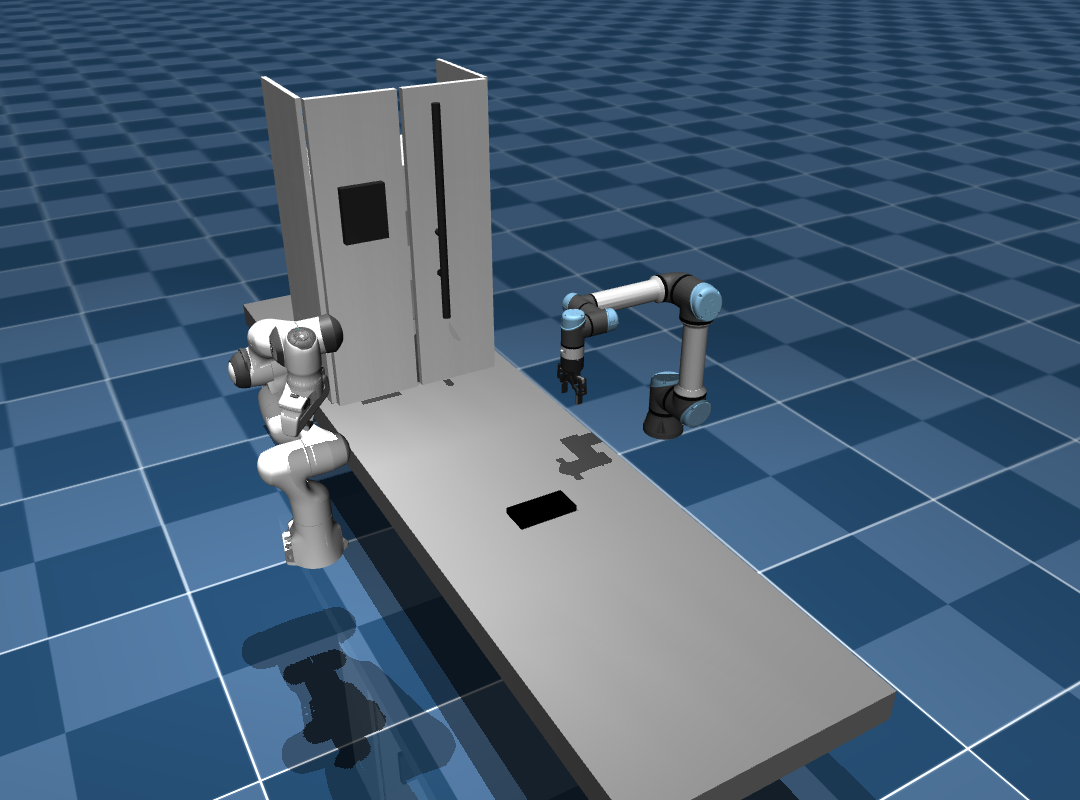

In [8]:
doorcabinet.reset_to_home_pose(render=True)

## NVISII Rendering

In [9]:
# import xml.etree.ElementTree as ET
# from robosuite.utils.mjcf_utils import string_to_array
# # from nvisii_utils import load_object

# xml_root = ET.fromstring(doorcabinet.model.to_xml_string())

# # parent_map = {c: p for p in xml_root.iter() for c in p}
# # # print(parent_map.get())
# # texture_attributes = {}
# # texture_id_mapping = {}

# # for texture in xml_root.iter("texture"):
# #     texture_type = texture.get("type")
# #     texture_name = texture.get("name")
# #     texture_file = texture.get("file")
# #     texture_rgb = texture.get("rgb1")

# #     if texture_file is not None:
# #         texture_attributes[texture_name] = texture.attrib
# #     else:
# #         color = np.array(string_to_array(texture_rgb))
# #         texture_id_mapping[texture_name] = (color, texture_type)

# # material_texture_mapping = {}
# # for material in xml_root.iter("material"):
# #     material_name = material.get("name")
# #     texture_name = material.get("texture")
# #     material_texture_mapping[material_name] = texture_name

# import os
# meshes = {}
# for mesh in xml_root.iter("mesh"):
#     # print(mesh.attrib)
#     meshes[mesh.get("name")] = mesh.attrib

# for i,v in enumerate(meshes.values()):
#     if i > 1:
#         v_new = v["file"].split('-')[0] + '.' + v["file"].split('.')[-1] 
#         # print(v_new, os.path.joi(v_new))

# # i=
# # for geom_index, geom in enumerate(xml_root.iter("geom")):
# #     print(geom_index)
# #     if geom.get("mesh") is not None:
# #         print(geom.get("mesh"), geom.get("file"))

# doorcabinet.physics.model.material(doorcabinet.physics.model.geom(1).matid + 16)
# np.where(doorcabinet.physics.model.geom_type == 7)[0][0]
# doorcabinet.physics.model.geom(15).type.item()
# doorcabinet.physics.model.texture(0)

# from nvisii_parser import Parser
# p = Parser("nvisii", doorcabinet, "")

# p.parse_textures()
# p.texture_attributes
# for i in range(doorcabinet.physics.model.ngeom):
#     geom = doorcabinet.physics.model.geom(i)
#     # print(geom.name)
#     for idx, g in enumerate(xml_root.iter("geom")):
#         if g.get("name") == geom.name and g.get("mesh") is not None:
#             print(g.get("name"), g.get("mesh"))
#             print(meshes[g.get("mesh")])
# doorcabinet.physics.model.ngeom

In [10]:
import sys
sys.path.append('/home/adityadutt/Desktop/robot-collab-v2/nvisii_scripts')

In [11]:
import importlib
import nvisii
from nvisii_scripts import nvisii_parser, nvisii_base_parser
import nvisii_scripts.nvisii_renderer as nvisii_renderer

importlib.reload(nvisii_renderer)

/home/adityadutt/miniconda3/envs/roco/lib/python3.8/site-packages/robosuite/macros.py:53: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead
  ROBOSUITE_DEFAULT_LOGGER.warn("No private macro file found!")
[robosuite WARNING] No private macro file found! (macros.py:53)
/home/adityadutt/miniconda3/envs/roco/lib/python3.8/site-packages/robosuite/macros.py:54: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead
  ROBOSUITE_DEFAULT_LOGGER.warn("It is recommended to use a private macro file")
[robosuite WARNING] It is recommended to use a private macro file (macros.py:54)
/home/adityadutt/miniconda3/envs/roco/lib/python3.8/site-packages/robosuite/macros.py:55: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead
  ROBOSUITE_DEFAULT_LOGGER.warn("To setup, run: python {}/scripts/setup_macros.py".format(robosuite.__path__[0]))
[robosuite WARNING] To setup, run: python /home/adityadutt/miniconda3/envs/roco/lib/python3.8/site-pa

<module 'nvisii_scripts.nvisii_renderer' from '/home/adityadutt/Desktop/robot-collab-v2/nvisii_scripts/nvisii_renderer.py'>

In [12]:
# render.light_1.get_light().set_intensity(150)
# render = nvisii_renderer.NVISIIRenderer(env=doorcabinet, width=800, height=800)

# texture_attributes, texture_id_mapping
# material_texture_mapping
# meshes
# render.render()
# render._init_lighting()
# render._camera_configuration(at_vec=nvisii.vec3(0, 0, -5.06), up_vec=np.array([0,0,1]), eye_vec=nvisii.vec3(5.24, 0.0, -3.05), quat=np.array([1,0,0,0]))
# # render.img_cntr = 0
# render.render(render_type="png")

In [13]:
### Render a simple environment ###
# basic_env_xml = """
# <mujoco>
#     <default class="hingecabinet">
#         <joint damping="2" frictionloss="2" armature=".01" limited="true"/> 
#         <default class="hinge_collision">
#             <!-- <geom conaffinity="1" condim="3" contype="0" group="4" margin="0.001" material="hinge_collision_blue" solimp=".8 .9 .01" solref=".02 1"/> -->
#             <geom type="box" material="white-wood" group="3"/> 
#         </default>
#         <default class="hinge_visual">
#             <geom type="box" material="white-wood"/>
#         </default> 
#     </default>
#     <asset>
#         <!-- cabinet -->
#         <texture file="rocobench/envs/assets/objects/textures/white-wood.png" type="2d" name="tex-white-wood"/>
#         <material name="white-wood" reflectance="0.6" texrepeat="15 15" texture="tex-white-wood" texuniform="true"/>
#         <material name="quiet-black" rgba=".15 .15 .15 1" reflectance=".2" shininess=".2" />
#     </asset>
    
#     <worldbody>
#     <body name="cabinet" pos="-0.7 0.5 0.5"  quat="0.707 0 0 0.707" >
#     <!-- <freejoint name="cabinet_joint" />  -->
#         <body name="cabinet_body" pos = "0. 0. 0.2">

#             <!-- Collision Geoms -->
#             <geom class="hinge_collision" name="cabinet_right_c" pos="0.34 0 0" size="0.01 0.2 0.6" type="box" mass=".2"/>
#             <geom class="hinge_collision" name="cabinet_left_c" pos="-0.34 0 0" size="0.01 0.2 0.6" type="box" mass=".2"/>
#             <geom class="hinge_collision" name="cabinet_top_c" pos="0 0 0.3" size="0.35 0.2 0.03" type="box" mass=".2"/>
#             <geom class="hinge_collision" name="cabinet_bottom_c" pos="0 0 -0.3" size="0.35 0.2 0.03" type="box" mass=".2"/>
#             <geom class="hinge_collision" name="cabinet_back_c" pos="0 0.19 0" size="0.33 0.015 0.3" type="box" mass=".2"/>            
#             <geom class="hinge_collision" name="cabinet_panel_c" pos="0 0 0" size="0.33 0.2 0.03" type="box" mass=".2" />
            
#             <!-- Visual Geoms -->
#             <geom class="hinge_visual" name="cabinet_right" pos="0.34 0 0" size="0.01 0.2 0.6" type="box" mass=".2"/>
#             <geom class="hinge_visual" name="cabinet_left" pos="-0.34 0 0" size="0.01 0.2 0.6" type="box" mass=".2"/>
#             <geom class="hinge_visual" name="cabinet_top" pos="0 0 0.3" size="0.35 0.2 0.03" type="box" mass=".2"/>
#             <geom class="hinge_visual" name="cabinet_bottom" pos="0 0 -0.3" size="0.35 0.2 0.03" type="box" mass=".2"/>
#             <geom class="hinge_visual" name="cabinet_back" pos="0 0.19 0" size="0.33 0.015 0.3" type="box" mass=".2"/>            
#             <geom class="hinge_visual" name="cabinet_panel" pos="0 0 0" size="0.33 0.2 0.03" type="box" mass=".2" />

#             <body name="cabinet_leftdoor" pos="-0.34 -0.2 0">
#                 <geom name="leftdoor_c" class="hinge_collision" pos="0.17 -0.02 0" size="0.16 0.015 0.6" type="box" mass="3"/>
#                 <geom name="leftdoor" class="hinge_visual" pos="0.17 -0.02 0" size="0.16 0.015 0.6" type="box" mass="3"/>
#                 <body name="key-reader" pos="0 0 0">
#                     <geom material="quiet-black" name="keyreader" pos="0.17 -0.05 0.2" size="0.08 0.015 0.1" type="box" mass="3"/>
#                 </body>
#             </body>
            
#             <body name="cabinet_rightdoor" pos="0.34 -0.2 0">
#                 <joint axis="0 0 1" name="rightdoorhinge" range="0 2.6" damping="100"/> 
#                 <inertial mass=".6" pos="-0.03 -0.02 0" diaginertia="0.01 0.01 0.01"/>
#                 <!-- Make the door bigger along z-axis -->
#                 <geom name="rightdoor_c" class="hinge_collision" pos="-0.17 -0.02 0" size="0.16 0.015 0.6" type="box" mass="3"/>
#                 <geom name="righthandle_c" class="hinge_collision" material="quiet-black" pos="-0.23 -0.08 0.15" size="0.015 0.4" type="cylinder" mass=".2"/>
#                 <geom name="righthandle_top_c" class="hinge_collision" pos="-0.23 -0.061 0.08" material="quiet-black" euler="1.57 0 0" size="0.013 0.02 0.02" type="cylinder" mass=".02"/>
#                 <geom name="righthandle_bottom_c" class="hinge_collision" pos="-0.23 -0.061 -0.08" material="quiet-black" euler="1.57 0 0" size="0.013 0.02 0.02" type="cylinder" mass=".02"/>
                
#                 <!-- Visual Geoms -->
#                 <geom name="rightdoor" class="hinge_visual" pos="-0.17 -0.02 0" size="0.16 0.015 0.6" type="box" mass="3"/>
#                 <geom name="righthandle" class="hinge_visual" material="quiet-black" pos="-0.23 -0.08 0.15" size="0.015 0.4" type="cylinder" mass=".2"/>
#                 <geom name="righthandle_top" class="hinge_visual" pos="-0.23 -0.061 0.08" material="quiet-black" euler="1.57 0 0" size="0.013 0.02 0.02" type="cylinder" mass=".02"/>
#                 <geom name="righthandle_bottom" class="hinge_visual" pos="-0.23 -0.061 -0.08" material="quiet-black" euler="1.57 0 0" size="0.013 0.02 0.02" type="cylinder" mass=".02"/>                
                
                
#                 <site name="cabinet_rdoor" type="sphere"  pos="-0.23 -0.13 0" size=".02" group="3" rgba="0 1 0 1" euler="1.57 0 1.57"/>
#                 <body name="right_door_handle" pos="-0.23 -0.1 0" euler="1.57 0 1.57"/>
#                 <site name="right_door_handle" pos="-0.23 -0.1 0" euler="1.57 0 1.57" group="3"/>
#                 <!-- <geom class="hinge_collision" pos="-0.302 -0.128 0" size="0.022 0.16" type="cylinder" mass=".1"/>
#                 <geom class="hinge_collision" pos="-0.302 -0.061 -0.114" euler="1.57 0 0" size="0.019 0.053 0.02" type="cylinder" mass=".02"/>
#                 <geom class="hinge_collision" pos="-0.302 -0.061 0.114" euler="1.57 0 0" size="0.019 0.053 0.02" type="cylinder" mass=".02"/>
#                 <geom class="hinge_collision" pos="-0.185 -.015 0" size="0.193 0.03 0.2" type="box" mass=".2"/>
#                 <site type="sphere" name="rightdoor_site" pos="-0.302 -0.128 0" size=".01" group="3" rgba="0 1 0 1"/> -->
#             </body>
#         </body>
#     </body>
#     </worldbody>
# </mujoco>
# """


# basic_env = BaseTask(model_name = "basic_env")

# cabinet = mjcf.from_file("rocobench/envs/assets/cabinet/cabinet_mjcf.xml")
# cabinet.model = "cabinet"
# basic_env.model.attach(cabinet)
# basic_env.physics = mjcf.Physics.from_mjcf_model(basic_env.model)

# phy = mjcf.Physics.from_xml_string(basic_env_xml)
r = nvisii_renderer.NVISIIRenderer(env=doorcabinet, width=800, height=800)

In [17]:
r._camera_configuration(at_vec=nvisii.vec3(0, 0, -5.06), up_vec=np.array([0,0,1]), eye_vec=nvisii.vec3(5.5, 0.0, -5.05), quat=np.array([1,0,0,0]))
# render.img_cntr = 0
r.render(render_type="png")

Rendering image... 4


In [28]:
r.close()

In [ ]:
# %reload_ext autoreload
# from nvisii_utils import load_object
# from nvisii_parser import Parser


# p = Parser("nvisii", doorcabinet, "")

# p.parse_geometries()

In [ ]:
# doorcabinet.reset_to_home_pose(render=True)
print(doorcabinet.physics.named.data.geom_pos["panda/link2_collision"] - doorcabinet.physics.named.data.geom_xpos["panda/link2_collision"])

print(doorcabinet.physics.named.model.body_pos["panda/link2"])

In [ ]:
### Kinova Home Qpos:[0.01, 1.6014, -1.06811, 0.06283, -0.94245, 3.1415, 1.06811, 0.00705532]
# kinova_qpos = [0.0411018, 1.57, -0.31415, 0.06283, -1.19377, -0.06283, -1.44509, 1.67465]
# ur5e_qpos = [0., -1.5708, -1.5708, 1.5708, -1.5708, -1.5708, 0.]

# reset_qpos = ur5e_qpos + kinova_qpos
# qpos_ids = [i for i in range(8, 15)] + [j for j in range(33, 41)]

# print(reset_qpos, qpos_ids)

# doorcabinet.render_image(qpos = reset_qpos, qpos_id = qpos_ids, cam_id = 6)

In [ ]:
# # from rocobench.envs.robot import SimRobot

# # panda1_constants = append_robot_names("panda1",PANDA_CONSTANTS)
# # panda2_constants = append_robot_names("panda2",PANDA_CONSTANTS)
# # ur5e_constants = append_robot_names("ur5e",UR5E_ROBOTIQ_CONSTANTS)
# # # kinova_constants = append_robot_names("kinova",KINOVA_CONSTANTS)
# panda_config = robots["panda"]["robot_config"]
# ur5e_config = robots["ur5e"]["robot_config"]

# # panda1=SimRobot(physics=doorcabinet.physics,use_ee_rest_quat=False,**panda1_constants)
# panda=SimRobot(physics=doorcabinet.physics,use_ee_rest_quat=False,**panda_config)


# # panda =SimRobot(physics=doorcabinet.physics,
                                
# #         name: str,
# #         all_joint_names: List[str],
# #         ik_joint_names: List[str],
# #         arm_joint_names: List[str],
# #         actuator_info: Dict[str, Any],
# #         all_link_names: List[str],
# #         arm_link_names: List[str], # 
# #         ee_link_names: List[str],
# #         base_joint: str,
# #         ee_site_name: str,
# #         grasp_actuator: str,    
                
                
                
                
                
                
# #                 )
# ur5e = SimRobot(physics=doorcabinet.physics,use_ee_rest_quat=False,**ur5e_config)
# # # kinova = SimRobot(physics=doorcabinet.physics,use_ee_rest_quat=False,**kinova_constants)

# # # robots={'panda1':panda1,'panda2':panda2}
# # robots={'ur5e':ur5e,'panda2':panda2}

# ur5e.ik_joint_names, panda.ik_joint_names

## Rendering the final environment

In [31]:
##UR5E RESET POS: qpos="-1.5708 -1.5708 1.5708 -1.5708 -1.5708 0"

##PANDA RESET POSE: qpos="0 0 0 0 -1.57079 0 1.57079 -0.7853 0.04 0.04"

# def reset_to_home_pose(physics, joint_ids, render=False):
#     physics.reset()
#     # with doorcabinet.physics.reset_context():
#     physics.named.model.eq_active["keycard_panda"] = False
#     physics.named.data.qpos["keycard_joint"] = [0.5, 0.5, 0.17, 1., 0., 0., 0.]
#     physics.named.model.eq_active["door_handle_panda"] = False
#         # qpos="0 0 0 -1.57079 0 1.57079 -0.7853 0.04 0.04"
#         # physics.data.qpos[joint_ids["panda1"]["qpos"] + joint_ids["panda2"]["qpos"]] = [0., 0., 0., 0., -1.57079, 0, 1.57079, -0.7853]*2 
#     physics.data.qpos[joint_ids["ur5e"]["qpos"]] = [-1.5708, -1.5708, 1.5708, -1.5708, -1.5708, 0., 0.] # (9, 10, 11, 12, 13, 14, 8)
#     physics.data.qpos[joint_ids["panda"]["qpos"]] = [0., -1.3, 0., -2.5, 0, 1., 0., 0.]

#     physics.data.ctrl = 0.

#     ##Kinova home pos
#     # physics.data.qpos[np.arange(33, 41)] = [0.0411018, 1.57, -0.31415, 0.06283, -1.19377, -0.06283, -1.44509, 1.67465]

#     # physics.data.ctrl = 0.
#     physics.data.qvel = 0.
#     physics.step()

#     if render:
#         img = PIL.Image.fromarray(physics.render(camera_id=6, width=1080, height=800))
#         return img
    
#     return None

# joint_ids = {#"panda1": {"qpos":panda1.joint_idxs_in_qpos, "ctrl":panda1.joint_idxs_in_ctrl}, 
#              "panda": {"qpos":panda.joint_idxs_in_qpos, "ctrl":panda.joint_idxs_in_ctrl},
#              "ur5e": {"qpos":ur5e.joint_idxs_in_qpos, "ctrl":ur5e.joint_idxs_in_ctrl}
#             }


# doorcabinet.reset_to_home_pose(render=True)
# doorcabinet.physics.step()
# PIL.Image.fromarray(doorcabinet.physics.render(camera_id=0, width = 1080, height = 800))

In [ ]:
ur5e.joint_idxs_in_qpos

## POLICY Section
Input a pair of target pose for both robot, then use the planner to generate motion traj. for both robots to reach the target pose

In [ ]:
# # # ## Move Stuff in Sim to test and work ##
# # # # doorcabinet.physics.named.data.qpos

# # #Define target poses and orientations
# keycard_pos = doorcabinet.physics.named.data.xpos["keycard"]
# keycard_quat = np.array([ 0., 1., 0., 0. ])

# doorhinge_pos = doorcabinet.physics.named.data.xpos["cabinet/right_door_handle"]
# doorhinge_quat = np.array([ 0., -0.707, 0., 0.707 ])


# pre_grasp_poses = {"doorhinge": {"pos": doorhinge_pos + np.array([.1, 0., 0.1 ]), "quat": doorhinge_quat}, 
#                     "keycard": {"pos": keycard_pos + np.array([0.0, 0.0, 0.14]), "quat": keycard_quat}    
#                 }

# doorhinge_result = ur5e.solve_ik(doorcabinet.physics, pre_grasp_poses["doorhinge"]["pos"], pre_grasp_poses["doorhinge"]["quat"])
# print(doorhinge_result)

# keycard_result = panda2.solve_ik(doorcabinet.physics, pre_grasp_poses["keycard"]["pos"], pre_grasp_poses["keycard"]["quat"])
# print(keycard_result)


## Implementing RRT 

In [ ]:
### Visualizing the data ###
%autoreload 2
from rocobench.rrt_multi_arm import MultiArmRRT

In [ ]:
doorcabinet.physics.named.data.xpos

In [ ]:
### create allowed_collision pairs: Cabinet IDs: (4 -> 10) UR5e IDs: (11 -> 34) Panda IDs: (35 -> 47)
allowed_collision_pairs = []
allowed_collision_pairs += [(1, 9), (1, 3), (1, 4), (1, 6)]
for i in range(4, 11):
    allowed_collision_pairs += [(j, i) for j in range(11, 35)] 
    allowed_collision_pairs += [(j, i) for j in range(35, 48)]

print(allowed_collision_pairs)

rrt = MultiArmRRT(doorcabinet.physics, 
                  robots,
                  allowed_collision_pairs=allowed_collision_pairs,
                  seed = 391)

#Ensuring No Initial Collisions
reset_to_home_pose(doorcabinet.physics, joint_ids, True)
start_qpos = doorcabinet.physics.data.qpos[ur5e.joint_idxs_in_qpos + panda2.joint_idxs_in_qpos].copy()

print(rrt.check_collision(start_qpos, physics=doorcabinet.physics))


with doorcabinet.physics.reset_context():
    doorcabinet.physics.data.qpos[ur5e.joint_idxs_in_qpos + panda2.joint_idxs_in_qpos] = start_qpos
    doorcabinet.physics.step()

    img = PIL.Image.fromarray(doorcabinet.physics.render(camera_id=0, width=1080, height=800))
img



In [ ]:
#Goal Pos: Keycard and DoorHinge
# p1_goal = rrt.solve_ik(doorcabinet.physics, 
#                        site_name=panda1.ee_site_name, 
#                        target_pos=doorhinge_pos + np.array([.2, 0., 0.1 ]), 
#                        target_quat=doorhinge_quat, 
#                        joint_names=panda1.ik_joint_names
#                     )

p1_goal = rrt.solve_ik(doorcabinet.physics, 
                       site_name=ur5e.ee_site_name, 
                       target_pos=doorhinge_pos + np.array([.0, 0., 0.0 ]), 
                       target_quat=[0., 0.707, 0., 0.707], 
                       joint_names=ur5e.ik_joint_names
                    )

# print(doorhinge_pos+ + np.array([.2, 0., 0.1 ]))

p2_goal = rrt.solve_ik(doorcabinet.physics, 
                       site_name=panda2.ee_site_name, 
                       target_pos=keycard_pos + np.array([0.0, 0.0, 0.14]), 
                       target_quat=keycard_quat, 
                       joint_names=panda2.ik_joint_names
                    )

# with doorcabinet.physics.reset_context():
#     q = doorcabinet.physics.data.qpos.copy()
#     q[ur5e.joint_idxs_in_qpos] = p1_goal.qpos[ur5e.joint_idxs_in_qpos]
#     q[panda2.joint_idxs_in_qpos] = p2_goal.qpos[panda2.joint_idxs_in_qpos]
#     doorcabinet.physics.data.qpos = q
#     doorcabinet.physics.step()
#     img = PIL.Image.fromarray(doorcabinet.physics.render(camera_id=0, width = 1080, height = 800))

# img

#Second Path
keyreader_pos = doorcabinet.physics.named.data.xpos["cabinet/key-reader"]
keyreader_pos += np.array([.3, 0.2, 0.2])
keyreader_quat = np.array([0., -0.707, 0., 0.707])

p2_second_goal = rrt.solve_ik(doorcabinet.physics, 
                       site_name=panda2.ee_site_name, 
                       target_pos= keyreader_pos, 
                       target_quat=keyreader_quat, 
                       joint_names=panda2.ik_joint_names
                    )


# with doorcabinet.physics.reset_context():
#     q = doorcabinet.physics.data.qpos.copy()
#     q[ur5e.joint_idxs_in_qpos] = p1_goal.qpos[ur5e.joint_idxs_in_qpos]
#     q[panda2.joint_idxs_in_qpos] = p2_second_goal.qpos[panda2.joint_idxs_in_qpos]
#     doorcabinet.physics.data.qpos = q
#     doorcabinet.physics.step()
#     img = PIL.Image.fromarray(doorcabinet.physics.render(camera_id=0, width = 1080, height = 800))

# img

# #Third Path Open the Door
# p1_second_goal = rrt.solve_ik(doorcabinet.physics, 
#                        site_name=panda1.ee_site_name, 
#                        target_pos= doorcabinet.open_door_pose[:3], 
#                        target_quat=doorcabinet.open_door_pose[3:], 
#                        joint_names=panda1.ik_joint_names
                    
print(doorcabinet.open_door_pose)
p1_second_goal = rrt.solve_ik(doorcabinet.physics, 
                       site_name=ur5e.ee_site_name, 
                       target_pos= doorcabinet.open_door_pose[:3], #+[0.5, 0., 0.1], 
                       target_quat=doorcabinet.open_door_pose[3:], 
                       joint_names=ur5e.ik_joint_names
                    )

# #To see the pose but not actually change physics state

with doorcabinet.physics.reset_context():
   q = doorcabinet.physics.data.qpos.copy()
   #  q[panda1.joint_idxs_in_qpos] = p1_second_goal.qpos[panda1.joint_idxs_in_qpos]
   q[ur5e.joint_idxs_in_qpos] = p1_second_goal.qpos[ur5e.joint_idxs_in_qpos]

   q[panda2.joint_idxs_in_qpos] = p2_second_goal.qpos[panda2.joint_idxs_in_qpos]
   doorcabinet.physics.data.qpos = q
   doorcabinet.physics.step()
   img = PIL.Image.fromarray(doorcabinet.physics.render(camera_id=0, width = 1080, height = 800))

img


Planning the Path using rrt.plan()

In [ ]:
# print(len(p1_goal.qpos), len(p2_goal.qpos), len(p1_second_goal.qpos), len(p2_second_goal.qpos), len(doorcabinet.physics.data.qpos))

In [ ]:
reset_to_home_pose(doorcabinet.physics, joint_ids, True)


In [ ]:

# first_goal_qpos = np.concatenate([start_qpos[panda1.joint_idxs_in_qpos], p2_goal.qpos[panda2.joint_idxs_in_qpos]])
# second_goal_qpos = np.concatenate([p1_goal.qpos[panda1.joint_idxs_in_qpos], p2_second_goal.qpos[panda2.joint_idxs_in_qpos]])
# third_goal_qpos = np.concatenate([p1_second_goal.qpos[panda1.joint_idxs_in_qpos], p2_second_goal.qpos[panda2.joint_idxs_in_qpos]])
# print(len(goal_qpos))
reset_to_home_pose(doorcabinet.physics, joint_ids, True)
first_goal_qpos = doorcabinet.physics.data.qpos.copy()
# first_goal_qpos[ur5e.joint_idxs_in_qpos] = start_qpos[ur5e.joint_idxs_in_qpos]
first_goal_qpos[panda2.joint_idxs_in_qpos] = p2_goal.qpos[panda2.joint_idxs_in_qpos]
# first_goal_qpos[ur5e.joint_idxs_in_qpos] = 

second_goal_qpos = p1_goal.qpos.copy()
second_goal_qpos[panda2.joint_idxs_in_qpos] = p2_second_goal.qpos[panda2.joint_idxs_in_qpos]

third_goal_qpos = p1_second_goal.qpos.copy()
third_goal_qpos[panda2.joint_idxs_in_qpos] = p2_second_goal.qpos[panda2.joint_idxs_in_qpos]
# first_goal_qpos = np.concatenate([start_qpos[ur5e.joint_idxs_in_qpos], p2_goal.qpos[panda2.joint_idxs_in_qpos]])
# second_goal_qpos = np.concatenate([p1_goal.qpos[ur5e.joint_idxs_in_qpos], p2_second_goal.qpos[panda2.joint_idxs_in_qpos]])
# third_goal_qpos = np.concatenate([p1_second_goal.qpos[ur5e.joint_idxs_in_qpos], p2_second_goal.qpos[panda2.joint_idxs_in_qpos]])

# print(len(second_goal_qpos), len(first_goal_qpos), len(third_goal_qpos))
# print(first_goal_qpos)

# doorcabinet.physics.reset()
paths, reason = rrt.plan(doorcabinet.physics.data.qpos, first_goal_qpos)
print(reason)

key_grasp_idx = len(paths) - 1

#Plan second path and append to paths
# second_start_pos = doorcabinet.physics.named.data.qpos[panda1.joint_idxs_in_qpos + panda2.joint_idxs_in_qpos].copy()
second_path, reason = rrt.plan(first_goal_qpos, second_goal_qpos)
print(reason)

paths += second_path
# print(len(paths[0]))      
door_grasp_idx = len(paths) - 1

#Plan third path and append to paths
third_path, reason = rrt.plan(second_goal_qpos, third_goal_qpos)
print(reason)  
paths += third_path


Visualizing the Control

In [ ]:
# # doorcabinet.physics.named.data.ctrl
# print(len(paths[0]))
# print(ur5e.joint_idxs_in_ctrl + panda2.joint_idxs_in_ctrl)
# print((ur5e.joint_idxs_in_qpos + panda2.joint_idxs_in_qpos))
# print(doorcabinet.physics.data.ctrl)

In [ ]:
scene_option = MjvOption()
scene_option.flags[enums.mjtVisFlag.mjVIS_JOINT] = True
scene_option.flags[enums.mjtRndFlag.mjRND_SHADOW] = True # play with these values
# img = physics.render(
# camera_id='xxx', width=xxx, height=xxx,
# scene_option=scene_option), 
# render_flag_overrides={mujoco.mjtRndFlag.mjRND_REFLECTION: False}, # also play with these
# ) 

In [ ]:
frames = []
ctrls=[]
duration=10
framerate=30
control_rate=0.005
doorcabinet.physics.reset()  # Reset state and time

#Reset to home pose for visualization
reset_to_home_pose(doorcabinet.physics, joint_ids)
doorcabinet.physics.named.model.eq_active["keycard_panda"] = False

# doorcabinet.physics.named.data.ctrl["panda1/panda_gripper_actuator"] = 255
doorcabinet.physics.named.data.ctrl["ur5e/robotiq_fingers_actuator"] = 255
doorcabinet.physics.named.data.ctrl["panda2/panda_gripper_actuator"] = 255


# Simulate and display video.
while doorcabinet.physics.data.time < duration:
    idx = int(doorcabinet.physics.data.time/ control_rate)

    if idx >= len(paths):
        idx = len(paths) - 1
    
    if idx >= key_grasp_idx:
        doorcabinet.physics.named.data.ctrl["panda2/panda_gripper_actuator"] = 0
        doorcabinet.physics.named.model.eq_active["keycard_panda"] = True


    if idx >= door_grasp_idx:
        doorcabinet.physics.named.data.ctrl["ur5e/robotiq_fingers_actuator"] = 0
        doorcabinet.physics.named.model.eq_active["door_handle_panda"] = True


    t0 = doorcabinet.physics.data.time
    # doorcabinet.physics.data.qpos[panda1.joint_idxs_in_qpos] = paths[idx][:num_panda_joints]
    # panda1_ctrl_vals = doorcabinet.physics.data.qpos[panda1.joint_idxs_in_qpos]
    # doorcabinet.physics.data.ctrl[panda1.joint_idxs_in_ctrl + panda2.joint_idxs_in_ctrl] = paths[idx]
    # doorcabinet.physics.data.ctrl[ur5e.joint_idxs_in_ctrl + panda2.joint_idxs_in_ctrl] = paths[idx][ur5e.joint_idxs_in_ctrl + panda2.joint_idxs_in_ctrl]

    qpos = doorcabinet.physics.data.qpos.copy()
    qpos[ur5e.joint_idxs_in_qpos + panda2.joint_idxs_in_qpos] = paths[idx]
    ctrl1 = ur5e.map_qpos_to_joint_ctrl(qpos)
    ctrl2 = panda2.map_qpos_to_joint_ctrl(qpos)

    doorcabinet.physics.data.ctrl[ctrl1["ctrl_idxs"]] = ctrl1["ctrl_vals"]
    doorcabinet.physics.data.ctrl[ctrl2["ctrl_idxs"]] = ctrl2["ctrl_vals"]

    # doorcabinet.physics.data.qpos[panda2.joint_idxs_in_qpos] = paths[idx][num_panda_joints:]
    # panda2_ctrl_vals = doorcabinet.physics.data.qpos[panda2.joint_idxs_in_qpos]
    # doorcabinet.physics.data.ctrl[panda2.joint_idxs_in_ctrl] = paths[idx][num_panda_joints:]

    # ctrl=np.concatenate((ctrl1["ctrl_vals"],[0],panda2_ctrl_vals,[0]))
    # doorcabinet.physics.data.ctrl=ctrl
    while doorcabinet.physics.data.time-t0<control_rate:
        doorcabinet.physics.step()
        if len(frames) < doorcabinet.physics.data.time * framerate:
            pixels = doorcabinet.physics.render(camera_id=0, width=1080,height=800)#, scene_option=scene_option), render_flag_overrides={mujoco.mjtRndFlag.mjRND_REFLECTION: False})
            frames.append(pixels)



In [ ]:
print(len(paths), idx)

In [ ]:
display_video(frames, framerate)

In [ ]:
print(doorcabinet.physics.named.model.eq_active)

In [ ]:
# # doorcabinet.physics.named.data.geom_xpos #data.contact.geom1
# from typing import Callable, List, Optional, Tuple, Union, Dict, Set, Any, FrozenSet
# #Right now only implemented for 2 Panda Robots

# class TaskAction():
#     def __init__(self, physics, robots: Dict[str, SimRobot] = {}, allowed_collision_pairs = []):
#         self.physics = physics
#         self.paths = []
#         self.robots = robots #Dictionary

#         #Modify to take in any number of robots of any type
#         self.panda1 = robots["panda1"]
#         self.panda2 = robots["panda2"]
#         self.joint_ids = {"panda1": {"qpos":panda1.joint_idxs_in_qpos, "ctrl":panda1.joint_idxs_in_ctrl}, 
#                           "panda2": {"qpos":panda2.joint_idxs_in_qpos, "ctrl":panda2.joint_idxs_in_ctrl}
#                         }

#         self.physics.named.model.eq_active["keycard_panda"] = False
#         self.physics.named.model.eq_active["door_handle_panda"] = False

#         self.rrt = MultiArmRRT( self.physics,
#                                 self.robots,
#                                 allowed_collision_pairs=allowed_collision_pairs,
#                                 seed = 391
#                             )
                    
#         self.start_qpos = self.physics.named.data.qpos[self.panda1.joint_idxs_in_qpos + self.panda2.joint_idxs_in_qpos].copy()
#         # self.panda_path_joint_idxs = len(self.panda1.joint_idxs_in_qpos) #Assume same num joints for each panda arm
        
#     def reset_to_home_pose(self, render=False):
#         self.physics.reset_context()

#         self.physics.named.data.qpos["keycard_joint"] = [0.5, 0.5, 0.15, 1., 0., 0., 0.]
#         self.physics.named.model.eq_active["keycard_panda"] = False
#         self.physics.named.model.eq_active["door_handle_panda"] = False
#         self.physics.data.qpos[self.joint_ids["panda1"]["qpos"] + self.joint_ids["panda2"]["qpos"]] = [0., 0., 0., 0., -1.57079, 0, 1.57079, -0.7853]*2 
#         self.physics.step()

#         if render:
#             img = PIL.Image.fromarray(self.physics.render(camera_id=0, width=1080, height=800))
#             return img
        
#         return None


#     def move_pre_grasp_pose(self, pre_grasp_poses, reset_to_home: bool = False):

#         if reset_to_home:
#             self.reset_to_home_pose()

        
#         doorhinge_pos = pre_grasp_poses["doorhinge"]["pos"]
#         doorhinge_quat = pre_grasp_poses["doorhinge"]["quat"]

#         keycard_pos = pre_grasp_poses["keycard"]["pos"]
#         keycard_quat = pre_grasp_poses["keycard"]["quat"]

#         #Find goal qpos for both arms
#         p1_goal = self.rrt.solve_ik(self.physics, 
#                        site_name=self.panda1.ee_site_name, 
#                        target_pos=doorhinge_pos, 
#                        target_quat=doorhinge_quat, 
#                        joint_names=self.panda1.ik_joint_names
#                     )
#         p2_goal = self.rrt.solve_ik(self.physics, 
#                        site_name=self.panda2.ee_site_name, 
#                        target_pos=keycard_pos, 
#                        target_quat=keycard_quat, 
#                        joint_names=self.panda2.ik_joint_names
#                     )

#         # #Ensure the arm is at home pose before calling move_pre_grasp
#         # reset_to_home_pose(self.physics, self.panda1.joint_idxs_in_ctrl, self.panda2.joint_idxs_in_ctrl)

#         goal_qpos = np.concatenate([p1_goal.qpos[self.panda1.joint_idxs_in_qpos], p2_goal.qpos[self.panda2.joint_idxs_in_qpos]])

#         self.physics.reset_context()
#         paths, reason = self.rrt.plan(start_qpos, goal_qpos)

#         if paths is None:
#             return "Move to pre-grasp pose Failed!"
#         else:
#             print("Moving to pre-grasp pose")
#             self.paths += paths
        
#         self.grasp_idx = len(paths) - 1

#     #Add robot name as argument to generalize 
#     def grasp(self, grasp_object:str, pre_grasp_poses):

    
#         #Either control the keycard or the doorhandle not both!
#         self.physics.model.eq_active(grasp_object + "_panda")
    
#         # self.paths += [None]
#         self.grasp_idx = len(self.paths) - 1

#         # self.physics.step()

#         #Hopefully this succeeds after holding the keycard
#         self.move_pre_grasp_pose(pre_grasp_poses)

#     def move_to_next_pose(curr_pose, tar_pose):
#         #Second Path
#         keyreader_pos = self.physics.named.data.xpos["cabinet/key-reader"]
#         keyreader_pos += np.array([.25, 0.2, 0.2])
#         keyreader_quat = np.array([0., -0.707, 0., 0.707])

#         p1_goal = self.rrt.solve_ik(self.physics, 
#                 site_name=self.panda1.ee_site_name, 
#                 target_pos=doorhinge_pos, 
#                 target_quat=doorhinge_quat, 
#                 joint_names=self.panda1.ik_joint_names
#             )

#         p2_second_goal = self.rrt.solve_ik(self.physics, 
#                             site_name=self.panda2.ee_site_name, 
#                             target_pos= keyreader_pos, 
#                             target_quat=keyreader_quat, 
#                             joint_names=self.panda2.ik_joint_names
#                             )
        
#         #Moving to keycard reader for now
#         second_goal_qpos = np.concatenate([p1_goal.qpos[panda1.joint_idxs_in_qpos], p2_second_goal.qpos[panda2.joint_idxs_in_qpos]])

#         self.physics.reset_context()
#         paths, reason = self.rrt.plan(start_qpos, second_goal_qpos)

#         if paths is None:
#             return "Move to next pose Failed!"
#         else:
#             print("Moving to pre-grasp pose")
#             self.paths += paths

#     def visualize(self, duration: int = 5, framerate = 30, control_rate = 0.01):
#         print("Visualizing the Path")
#         frames = []
#         ctrls=[]
        
#         self.physics.reset()  # Reset state and time

#         while self.physics.data.time < duration:
#             idx = int(self.physics.data.time/ control_rate)

#             if idx >= len(self.paths):
#                 idx = len(self.paths) - 1

#             if(idx >= self.grasp_idx):
#                 self.physics.named.model.eq_active["keycard_panda"] = True

#             t0 = self.physics.data.time
            
#             #Modify This!
#             self.physics.data.ctrl[self.panda1.joint_idxs_in_ctrl + self.panda2.joint_idxs_in_ctrl] = self.paths[idx]

#             while self.physics.data.time - t0 < control_rate:
#                 self.physics.step()
#                 if len(frames) < self.physics.data.time * framerate:
#                     pixels = self.physics.render(camera_id=0, width=1080,height=800)
#                     frames.append(pixels)

#         display_video(frames, framerate)


In [ ]:
# doorcabinet_task = TaskAction(doorcabinet.physics, robots, allowed_collision_pairs = [(1, 9), (1,3),(1, 4), (1, 6)])

# # reset_to_home_pose(doorcabinet.physics, panda1.joint_idxs_in_ctrl, panda2.joint_idxs_in_ctrl)

# #Move to pre-grasp pose
# pre_grasp_poses = {"doorhinge": {"pos": doorhinge_pos + np.array([.1, 0., 0.1 ]), "quat": doorhinge_quat}, 
#                     "keycard": {"pos": keycard_pos + np.array([0.0, 0.0, 0.14]), "quat": keycard_quat}    
#                 }

# doorcabinet_task.move_pre_grasp_pose(pre_grasp_poses, reset_to_home=True)

# # doorcabinet_task.move_to_next_pose()

# #Visualize
# doorcabinet_task.visualize(duration=5)


In [ ]:
doorcabinet.physics.named.data.xquat

In [ ]:
doorcabinet.physics.named.data.geom_xpos


## Working with CUROBO

In [64]:
import curobo
import torch 

In [65]:
keycard_pos = doorcabinet.physics.named.data.xpos["keycard"].copy()
keycard_quat = np.array([ 0., 1., 0., 0. ])

print("Key Card World Pos: ", keycard_pos)

doorhinge_pos = doorcabinet.physics.named.data.xpos["cabinet/right_door_handle"].copy()
doorhinge_quat = np.array([ 0., -0.707, 0., 0.707 ])

print("Door Hinge World Pos: ", doorhinge_pos)

keyreader_pos = doorcabinet.physics.named.data.xpos["cabinet/key-reader"].copy()
keyreader_pos += np.array([.3, 0.2, 0.2])
keyreader_quat = np.array([0., -0.707, 0., 0.707])

print("Key Reader World Pos: ", keyreader_pos)

Key Card World Pos:  [0.5        0.5        0.17031118]
Door Hinge World Pos:  [-0.4   0.61  0.7 ]
Key Reader World Pos:  [-0.2   0.36  0.9 ]


In [ ]:
# doorcabinet.physics.named.data.geom_xpos

In [ ]:
# kinova_xpos = doorcabinet.physics.data.body("kinovagen3/").xpos
# kinova_xquat = doorcabinet.physics.data.body("kinovagen3/").xquat
# kinova_pose = np.concatenate([kinova_xpos, kinova_xquat])
# kinova_pose
# doorcabinet.physics.named.data.geom_xpos[100]

In [ ]:
# doorcabinet.physics.named.data.xpos
# append_robot_names("panda", PANDA_CONSTANTS)["arm_joint_names"]

In [ ]:
# import quaternion 
# def rotation_matrix_to_quaternion(rot_mat):
#     # Reshape the 1D array into a 3x3 matrix
#     rot_mat = np.reshape(rot_mat, (3, 3))
    
#     # Extract components of the rotation matrix
#     trace = np.trace(rot_mat)
#     if trace > 0:
#         S = np.sqrt(trace + 1.0) * 2
#         qw = 0.25 * S
#         qx = (rot_mat[2, 1] - rot_mat[1, 2]) / S
#         qy = (rot_mat[0, 2] - rot_mat[2, 0]) / S
#         qz = (rot_mat[1, 0] - rot_mat[0, 1]) / S
#     elif rot_mat[0, 0] > rot_mat[1, 1] and rot_mat[0, 0] > rot_mat[2, 2]:
#         S = np.sqrt(1.0 + rot_mat[0, 0] - rot_mat[1, 1] - rot_mat[2, 2]) * 2
#         qw = (rot_mat[2, 1] - rot_mat[1, 2]) / S
#         qx = 0.25 * S
#         qy = (rot_mat[0, 1] + rot_mat[1, 0]) / S
#         qz = (rot_mat[0, 2] + rot_mat[2, 0]) / S
#     elif rot_mat[1, 1] > rot_mat[2, 2]:
#         S = np.sqrt(1.0 + rot_mat[1, 1] - rot_mat[0, 0] - rot_mat[2, 2]) * 2
#         qw = (rot_mat[0, 2] - rot_mat[2, 0]) / S
#         qx = (rot_mat[0, 1] + rot_mat[1, 0]) / S
#         qy = 0.25 * S
#         qz = (rot_mat[1, 2] + rot_mat[2, 1]) / S
#     else:
#         S = np.sqrt(1.0 + rot_mat[2, 2] - rot_mat[0, 0] - rot_mat[1, 1]) * 2
#         qw = (rot_mat[1, 0] - rot_mat[0, 1]) / S
#         qx = (rot_mat[0, 2] + rot_mat[2, 0]) / S
#         qy = (rot_mat[1, 2] + rot_mat[2, 1]) / S
#         qz = 0.25 * S
    
#     # Return the quaternion
#     return np.array([qw, qx, qy, qz])



In [ ]:
collision_geom_idx = np.where(doorcabinet.physics.model.geom_group == 3)[0]
# print(collision_geom_idx)

# doorcabinet.physics.model.geom_size[31]
# doorcabinet.physics.data.geom_id2name(31)

In [ ]:
# doorcabinet.physics.named.data.geom_xpos
doorcabinet.physics.model.geom(87).name.split('/')[0]


In [ ]:
# rotation_matrix_to_quaternion(doorcabinet.physics.data.geom_xmat[31])

In [ ]:
ur5e_assets_path = ""
panda_assets_path = ""

# rocobench/assets/panda"
# rocobench/assets/ur5e_robotiq/robotiq_assets"


panda_constants = append_robot_names("panda", PANDA_CONSTANTS.copy())
ur5e_constants = append_robot_names("ur5e", UR5E_ROBOTIQ_CONSTANTS.copy())
panda_meshes = panda_constants["mesh_to_geoms"]
ur5e_meshes = ur5e_constants["mesh_to_geoms"]

mesh_dict = {}

for key, v in panda_meshes.items():
    # mesh_dict[ panda_assets_path + '/' + key] = v
    mesh_dict[key] = v

for key, v in ur5e_meshes.items():
    # mesh_dict[ur5e_assets_path + '/' + key] = v
    mesh_dict[key] = v

print(mesh_dict.keys())

In [ ]:
# doorcabinet.physics.model.geom(87).type[0]

In [ ]:
# cuRobo
from curobo.types.math import Pose
from curobo.types.robot import JointState
from curobo.wrap.reacher.motion_gen import MotionGen, MotionGenConfig, MotionGenPlanConfig
from curobo.geom.types import WorldConfig, Cuboid, Mesh, Capsule, Cylinder, Sphere

# cabinet_right = Cuboid(
#     name="cabinet_right",
#     dims=[0.01, 0.2, 0.6],
#     pose=[-0.7, 0.84, 0.47, 0.707, 0, 0, 0.707],
# )

# obstacle_4 = Cylinder(
#    name="cylinder_1",
#    radius=0.2,
#    height=0.1,
#    pose=[0.0, 6, 0.0, 0.043, -0.471, 0.284, 0.834],
#    color=[0, 1.0, 0, 1.0],
# )

# obstacle_3 = Capsule(
#    name="capsule",
#    radius=0.2,
#    base=[0, 0, 0],
#    tip=[0, 0, 0.5],
#    pose=[0.0, 5, 0.0, 0.043, -0.471, 0.284, 0.834],
#    color=[0, 1.0, 0, 1.0],
# )

"""
Generate World Config Function

"""

def generate_world_config(physics, geom_group = 3, mesh_test = False, skip_robot_name = ""):
    world_config = {"cylinder": {}, "cuboid": {}, "mesh": {}, "capsule": {}}
    
    collision_geom_idx = np.where(physics.model.geom_group == geom_group)[0]
    
    ### Looping over Robot Meshes for world_config ####
    for i in collision_geom_idx:
        
        # Access the geom model and data
        geom = physics.model.geom(i)
        geom_data = physics.data.geom(i)

        if(geom.name.split("/")[0] == skip_robot_name):
            continue
        
        ## Check for different geom types ##
        if geom.type[0] == 2: #Sphere
            world_config["sphere"][geom.name] = {   "radius": float(geom.size[0]),
                                                    "pose": np.concatenate([geom_data.xpos, [1, 0, 0, 0]])
                                                }

        if geom.type[0] ==  3: #Capsule       
            world_config["capsule"][geom.name] = {  "radius": float(geom.size[0]),
                                                    "base": 0.0*float(geom.size[1]),
                                                    "tip": 2.0*float(geom.size[1]),
                                                    "pose": np.concatenate([geom_data.xpos, [1, 0, 0, 0]])
                                                }

        if geom.type[0] == 5: #Cylinder
            world_config["cylinder"][geom.name] = { "radius": float(geom.size[0]),
                                                    "height": 2.0*float(geom.size[1]),
                                                    "pose" : np.concatenate([geom_data.xpos, [1, 0, 0, 0]])
                                                }
        
        if geom.type[0] ==  6: #Cuboid
            # print(i)
            world_config["cuboid"][geom.name] = {   "dims": list(geom.size),
                                                    "pose": np.concatenate([geom_data.xpos, [1, 0, 0, 0]])
                                                }

        if geom.type[0] ==  7: #Mesh

            #Find the key for the mesh file
            mesh_file = find_key_from_value(mesh_dict, geom.name)

            world_config["mesh"][geom.name] = { "file_path": mesh_file,
                                                "pose": np.concatenate([geom_data.xpos, [1, 0, 0, 0]])
                                            }

    ### Testing Meshes Work ###
    if mesh_test:
        for key, value in world_config["mesh"].items():
            print(key, ":", value["file_path"])
    
    return world_config 

world_config = generate_world_config(doorcabinet.physics, mesh_test = True, skip_robot_name="ur5e")

## Previous World Config Instance

In [ ]:
# world_config = {
#     "mesh": {
#         # "kinova_base": {
#         #     "pose": kinova_pose,
#         #     "file_path": "/home/adityadutt/Desktop/robot-collab-v2/rocobench/envs/assets/kinova_with_base/meshes/base/mobile_base.obj",
#         # },
#         # "kinova_shoulder_link":{
#         #     "pose": kinova_pose,
#         #     "file_path":"/home/adityadutt/Desktop/robot-collab-v2/rocobench/envs/assets/kinova_with_base/meshes/arm_col/shoulder_link.STL"
#         # }
#         "ur5e_0_base":{
#             "pose": np.concatenate([doorcabinet.physics.data.body("ur5e/ur5e_0_base").xpos, 
#                                     doorcabinet.physics.data.body("ur5e/ur5e_0_base").xquat]),
#             "file_path":"/home/adityadutt/Desktop/robot-collab-v2/rocobench/envs/assets/ur5e_robotiq/ur5e_assets/base_0.obj"
#         },
#         "ur5e_0_forearm_link": {
#             "pose": np.concatenate([doorcabinet.physics.data.body("ur5e/ur5e_0_forearm_link").xpos, 
#                                     doorcabinet.physics.data.body("ur5e/ur5e_0_forearm_link").xquat]),
#             "file_path":"/home/adityadutt/Desktop/robot-collab-v2/rocobench/envs/assets/ur5e_robotiq/ur5e_assets/forearm_0.obj"
#         },
#         "ur5e_0_shoulder_link":{
#             "pose": np.concatenate([doorcabinet.physics.data.body("ur5e/ur5e_0_shoulder_link").xpos,
#                                     doorcabinet.physics.data.body("ur5e/ur5e_0_shoulder_link").xquat]),
#             "file_path":"/home/adityadutt/Desktop/robot-collab-v2/rocobench/envs/assets/ur5e_robotiq/ur5e_assets/shoulder_0.obj"
#         },
#         "ur5e_0_upper_arm_link":{
#             "pose": np.concatenate([doorcabinet.physics.data.body("ur5e/ur5e_0_upper_arm_link").xpos,
#                                     doorcabinet.physics.data.body("ur5e/ur5e_0_upper_arm_link").xquat]),
#             "file_path":"/home/adityadutt/Desktop/robot-collab-v2/rocobench/envs/assets/ur5e_robotiq/ur5e_assets/upperarm_0.obj"
#         },
#         "ur5e_0_wrist_1_link":{
#             "pose": np.concatenate([doorcabinet.physics.data.body("ur5e/ur5e_0_wrist_1_link").xpos,
#                                     doorcabinet.physics.data.body("ur5e/ur5e_0_wrist_1_link").xquat]),
#             "file_path":"/home/adityadutt/Desktop/robot-collab-v2/rocobench/envs/assets/ur5e_robotiq/ur5e_assets/wrist1_0.obj"
#         },
#         "ur5e_0_wrist_2_link":{
#             "pose": np.concatenate([doorcabinet.physics.data.body("ur5e/ur5e_0_wrist_2_link").xpos,
#                                     doorcabinet.physics.data.body("ur5e/ur5e_0_wrist_2_link").xquat]),
#             "file_path":"/home/adityadutt/Desktop/robot-collab-v2/rocobench/envs/assets/ur5e_robotiq/ur5e_assets/wrist2_0.obj"
#         },
#         "ur5e_0_wrist_3_link":{
#             "pose": np.concatenate([doorcabinet.physics.data.body("ur5e/ur5e_0_wrist_3_link").xpos,
#                                     doorcabinet.physics.data.body("ur5e/ur5e_0_wrist_3_link").xquat]),
#             "file_path":"/home/adityadutt/Desktop/robot-collab-v2/rocobench/envs/assets/ur5e_robotiq/ur5e_assets/wrist3.obj"
#         }
#     },

#     "cuboid": {
#         "table": {
#             "dims": [2.0, 2.0, 0.2],  # x, y, z = [0.33, 0.2, 0.03]
#             "pose": [0, 0.5, 0.11, 1, 0, 0, 0.0],  # x, y, z, qw, qx, qy, qz
#         },
#         "cabinet_right": {
#             "dims": [0.01, 0.2, 0.6],
#             "pose": [-0.7, 0.84, 0.47, 0.707, 0, 0, 0.707],
#         },
#         "cabinet_left": {
#             "dims": [0.01, 0.2, 0.6],
#             "pose": [-0.7, 0.16, 0.47, 1, 0, 0, 0],
#         },
#         "cabinet_top": {
#             "dims": [0.35, 0.2, 0.03],
#             "pose": [-0.7, 0.5, 0.77, 1, 0, 0, 0],
#         },
#         "cabinet_bottom": {
#             "dims": [0.35, 0.2, 0.03],
#             "pose": [-0.7, 0.5, 0.17, 1, 0, 0, 0],
#         },
#         "cabinet_back": {
#             "dims": [0.33, 0.015, 0.3],
#             "pose": [-0.89, 0.5, 0.47, 1, 0, 0, 0],
#         },
#         "cabinet_panel": {
#             "dims": [0.33, 0.2, 0.03],
#             "pose": [-0.7, 0.5, 0.47, 1, 0, 0, 0],
#         },
#         "cabinet_leftdoor": {
#             "dims": [0.16, 0.015, 0.6],
#             "pose": [-0.48, 0.33, 0.47, 0, 1, 0, 0],
#         }
#     }
# }

In [ ]:
# np.cos(np.pi)
print(doorcabinet.physics.named.data.xpos["panda/"], doorcabinet.physics.named.data.xpos["keycard"])
print(doorcabinet.physics.named.data.xpos["keycard"] - doorcabinet.physics.named.data.xpos["panda/"])

In [ ]:
from scipy.spatial.transform import Rotation as R

def transform_pose_robot(object_pose,robot_pose,verbose=False):
    robot_pose_x=robot_pose[0:3]
    robot_pose_q=robot_pose[[4,5,6,3]]
    object_pose_x=object_pose[0:3]
    object_pose_q=object_pose[[4,5,6,3]]
    robot_r=R.from_quat(robot_pose_q)
    object_r=R.from_quat(object_pose_q)
    new_pose_x=robot_r.inv().apply(object_pose_x-robot_pose_x)
    new_quat=robot_r.inv()*object_r
    if verbose:
        print(object_pose_q,robot_pose_q,robot_r.inv().as_matrix(),object_r.as_matrix())
    return np.concatenate((new_pose_x,new_quat.as_quat()[[3,0,1,2]]))


def update_curobo_world(physics,world_config,robot_name):
    #print(world_config)
    robot_pos=np.concatenate((physics.named.data.xpos[robot_name],physics.named.data.xquat[robot_name]),axis=0)
    for object_type in world_config:
        object_dict=world_config[object_type]
        for name in object_dict:
            new_xpos=physics.named.data.geom_xpos[name]
            new_quat=R.from_matrix(np.reshape(physics.named.data.geom_xmat[name],(3,3))).as_quat()[[3,0,1,2]]
            xpos_robot_frame=transform_pose_robot(np.concatenate((new_xpos,new_quat),axis=0),robot_pos)
            object_dict[name]['pose']=xpos_robot_frame

In [ ]:
##Transformation Matrices

##Panda rotated about z-axis from Mujoco World by 180 degrees
# def get_robot_transform(physics, robot_name):
#     t = physics.named.data.xpos[robot_name]
    
#     R = np.eye(3)

#     return {"R":R,"t":-R@t}

# panda_transform = get_robot_transform(doorcabinet.physics, "panda/")
# ur5e_transform = get_robot_transform(doorcabinet.physics, "ur5e/")
# kinova_transform = get_robot_transform(doorcabinet.physics, "kinovagen3/")
# print(panda_transform)

Generate world_config of obstacles for each robot

In [ ]:
# def transform_objects_to_robot_frame(objects:dict, robot_transform):

#     R = robot_transform["R"] 
#     t = robot_transform["t"]
#     result = objects.copy()
#     for key, v in objects["cuboid"].items():
#         new_pose = R@v["pose"][:3] + t
#         result["cuboid"][key]["pose"][:3] = new_pose            
    
#     return result
# panda_world_config  = transform_objects_to_robot_frame(panda_world_config, panda_transform)
# ur5e_world_config = transform_objects_to_robot_frame(panda_world_config, ur5e_transform)

panda_world_config = generate_world_config(doorcabinet.physics, mesh_test=True, skip_robot_name="panda")
panda_world_config = update_curobo_world(doorcabinet.physics, panda_world_config, "panda/")

ur5e_world_config = generate_world_config(doorcabinet.physics, mesh_test=True, skip_robot_name="ur5e")
ur5e_world_config = update_curobo_world(doorcabinet.physics, ur5e_world_config, "ur5e/")

In [ ]:
doorhinge_pose = np.concatenate([doorhinge_pos, doorhinge_quat])
keycard_pose = np.concatenate([keycard_pos, keycard_quat])
keyreader_pose = np.concatenate([keyreader_pos, keyreader_quat])

ur5e_pose = doorcabinet.get_robot_pose("ur5e/")



robot_doorhinge_pose = transform_pose_robot(doorhinge_pose, ur5e_pose)


# robot_doorhinge_pose = np.concatenate([ur5e_transform["R"]@(doorhinge_pos + [0.15, 0., 0.]) + ur5e_transform["t"], doorhinge_quat])
# robot_keycard_pose = np.concatenate([panda_transform["R"]@(keycard_pos) + panda_transform["t"] + [0., 0., 0.1], keycard_quat])
# robot_keyreader_pose = np.concatenate([panda_transform["R"]@(keyreader_pos + [0.02, 0., 0.])+ panda_transform["t"], keyreader_quat])

# robot_opendoor_pose = np.concatenate([ur5e_transform["R"]@(doorcabinet.open_door_pose[:3]) + ur5e_transform["t"], doorcabinet.open_door_pose[3:]])

# print(keycard_pose, "\t", keyreader_pose)
# print(robot_keycard_pose, "\t", robot_keyreader_pose)
# print(doorhinge_pose, "\t", robot_doorhinge_pose)
# robot_keycard_pose[:3], keycard_pose
robot_doorhinge_pose
# keycard_pose += [0., 0., 0.1, 0., 0., 0., 0. ]

In [ ]:
#Generate traj for panda to pick up keycard and show it to keyreader
# panda_motion_config = MotionGenConfig.load_from_robot_config("franka.yml", panda_world_config, interpolation_dt=1/30)
# panda_motion_gen = MotionGen(panda_motion_config)
# panda_motion_gen.warmup(parallel_finetune=True)

# panda_retract_cfg = panda_motion_gen.get_retract_config()
# print(panda_retract_cfg.view(-1, 1))

In [ ]:
# ur5e_motion_config = MotionGenConfig.load_from_robot_config("ur5e.yml", ur5e_world_config, interpolation_dt=1/30)
# ur5e_motion_gen = MotionGen(ur5e_motion_config)
# ur5e_motion_gen.warmup(parallel_finetune=True)

# ## [-1.5708, -1.5708, 1.5708, -1.5708, -1.5708, 0., 0.]
# ur5e_start_state = JointState.from_position(torch.tensor([-1.5708, -1.5708, 1.5708, -1.5708, -1.5708, 0.]).view(1, -1).cuda())

# ur5e_retract_cfg = ur5e_motion_gen.get_retract_config()
# print(ur5e_retract_cfg.view(-1, 1))

## Plan UR5E Trajectories

In [ ]:
ur5e_motion_config = MotionGenConfig.load_from_robot_config("ur5e.yml", ur5e_world_config, interpolation_dt=1/30)
ur5e_motion_gen = MotionGen(ur5e_motion_config)
ur5e_motion_gen.warmup(parallel_finetune=True)

## [-1.5708, -1.5708, 1.5708, -1.5708, -1.5708, 0., 0.]
ur5e_start_state = JointState.from_position(torch.tensor([-1.5708, -1.5708, 1.5708, -1.5708, -1.5708, 0.]).view(1, -1).cuda())

ur5e_retract_cfg = ur5e_motion_gen.get_retract_config()
print(ur5e_retract_cfg.view(-1, 1))

#### First Plan UR5e Pose
trajectory_ur5e = ur5e_start_state

pose_list = [robot_doorhinge_pose] #, robot_opendoor_pose]
motion_time = 0
for i, pose in enumerate(pose_list):
    goal_pose = Pose.from_list(pose, q_xyzw=False)
    start_state = trajectory_ur5e[-1].unsqueeze(0).clone()
    start_state.velocity[:] = 0.0
    start_state.acceleration[:] = 0.0
    result = ur5e_motion_gen.plan_single(
        start_state.clone(),
        goal_pose,
        plan_config=MotionGenPlanConfig(parallel_finetune=True, max_attempts=1),
    )
    if result.success.item():
        plan = result.get_interpolated_plan()
        trajectory_ur5e = trajectory_ur5e.stack(plan.clone())
        if(i == 0):
            trajectory_doorhandle = trajectory_ur5e[-1].clone()
            door_grasp_idx = len(trajectory_ur5e) - 1
        motion_time += result.motion_time
    else:
        print(i, "fail", result.status)
print("Motion Time (s):", motion_time, result.success)

## Plan Panda Trajectories

In [ ]:
# reset_to_home_pose(doorcabinet.physics, joint_ids)

with doorcabinet.physics.reset_context():
    #Move UR5e to doorhandle pose so that Panda can avoid collision
    doorcabinet.physics.data.qpos[ur5e.joint_idxs_in_qpos] = trajectory_ur5e[-1].position.clone().tolist() + [0.]
    doorcabinet.physics.step()
    ## Update World Config for Panda
    prefix = "ur5e/"
    for key, v in world_config["mesh"].items():
        world_config["mesh"][key]["pose"] = np.concatenate([doorcabinet.physics.data.body(prefix + key).xpos, doorcabinet.physics.data.body(prefix + key).xquat])


panda_world_config = transform_objects_to_robot_frame(world_config, panda_transform)

panda_motion_config = MotionGenConfig.load_from_robot_config("franka_mobile.yml", panda_world_config, interpolation_dt=1/30)
panda_motion_gen = MotionGen(panda_motion_config)
panda_motion_gen.warmup(parallel_finetune=True)

panda_retract_cfg = panda_motion_gen.get_retract_config()
print(panda_retract_cfg.view(-1, 1))

panda_start_state = JointState.from_position(panda_retract_cfg.view(1, -1))

# poses for panda: keycard_pose, keyreader_pose
#Home Pose: [0., 0.2, 0.5, 0, 1, 0, 0]
home_pose = [0, 0.2, 0.5, 0, 1, 0, 0]

new_keycard = robot_keycard_pose + [0., 0., 0.12, 0., 0., 0., 0.]#- [0.4, -0.15, 0., 0., 0., 0., 0.]
new_pose = robot_keyreader_pose #- [0.45, -0.05, 0.1, 0., 0., 0., 0.]

pose_list = [new_keycard, new_pose]
trajectory = panda_start_state

motion_time = 0
for i, pose in enumerate(pose_list):
    goal_pose = Pose.from_list(pose, q_xyzw=False)
    start_state = trajectory[-1].unsqueeze(0).clone()
    start_state.velocity[:] = 0.0
    start_state.acceleration[:] = 0.0
    result = panda_motion_gen.plan_single(
        start_state.clone(),
        goal_pose,
        plan_config=MotionGenPlanConfig(parallel_finetune=True, max_attempts=1),
    )
    if result.success.item():
        plan = result.get_interpolated_plan()
        trajectory = trajectory.stack(plan.clone())

        if(i == 0):
            trajectory_keycard = trajectory[-1].clone()
            key_grasp_idx = len(trajectory) - 1
        motion_time += result.motion_time
    else:
        print(i, "fail", result.status)
print("Motion Time (s):", motion_time)

# print("Trajectory: ", trajectory[-1])

In [ ]:
len(trajectory), len(trajectory_ur5e)

In [ ]:
traj = trajectory[-1].position.clone()
traj.tolist()

In [ ]:
# print(trajectory.position.shape)
with doorcabinet.physics.reset_context():
    reset_to_home_pose(doorcabinet.physics, joint_ids)
    qpos = trajectory_doorhandle.position.clone()
    qpos = qpos.tolist()
    doorcabinet.physics.data.qpos[ur5e.joint_idxs_in_qpos] = qpos + [0.]
    doorcabinet.physics.step()

    img = PIL.Image.fromarray(doorcabinet.physics.render(camera_id=0, width = 1080, height = 800))
img

In [ ]:
frames = []
# ctrls=[]
duration=7
framerate=20
control_rate=0.01

# Reset state and time

#Reset to home pose for visualization
reset_to_home_pose(doorcabinet.physics, joint_ids)

# doorcabinet.physics.named.data.ctrl["ur5e/robotiq_fingers_actuator"] = 255
# doorcabinet.physics.named.data.ctrl["panda2/panda_gripper_actuator"] = 255

#Make frames for the panda
while doorcabinet.physics.data.time < duration:
    t0 = doorcabinet.physics.data.time
    idx = int(doorcabinet.physics.data.time / control_rate)

    if idx >= len(trajectory_ur5e):
        idx = len(trajectory_ur5e) - 1
    
    # if idx >= key_grasp_idx:
    #     doorcabinet.physics.named.data.ctrl["panda2/panda_gripper_actuator"] = 10
    #     doorcabinet.physics.named.model.eq_active["keycard_panda"] = True

    if idx >= door_grasp_idx:
        doorcabinet.physics.named.data.ctrl["ur5e/robotiq_fingers_actuator"] = 255
        doorcabinet.physics.named.model.eq_active["door_handle_panda"] = True
        
    # doorcabinet.physics.data.ctrl[panda2.joint_idxs_in_ctrl] = trajectory[idx].position.clone()[[1,2,3,4,5,6,7,0]].tolist()
    doorcabinet.physics.data.ctrl[ur5e.joint_idxs_in_ctrl] = trajectory_ur5e[idx].position.clone().tolist() + [0.]

    while doorcabinet.physics.data.time-t0<control_rate:
        doorcabinet.physics.step()
        if len(frames) < doorcabinet.physics.data.time * framerate:
            pixels = doorcabinet.physics.render(camera_id=6, width=1080,height=800)
            frames.append(pixels)

# #Make frames for the ur5e
# idx = 0
# while doorcabinet.physics.data.time > duration/2 and doorcabinet.physics.data.time < duration:
#     t0 = doorcabinet.physics.data.time
#     idx = int(doorcabinet.physics.data.time / control_rate)

#     if idx >= len(trajectory_ur5e):
#         idx = len(trajectory_ur5e) - 1
    
#     if idx >= door_grasp_idx:
#         doorcabinet.physics.named.data.ctrl["ur5e/robotiq_fingers_actuator"] = 255
#         doorcabinet.physics.named.model.eq_active["door_handle_panda"] = True

    

#     while doorcabinet.physics.data.time-t0<control_rate:
#         doorcabinet.physics.step()
#         if len(frames) < doorcabinet.physics.data.time * framerate:
#             pixels = doorcabinet.physics.render(camera_id=6, width=1080,height=800)
#             frames.append(pixels)


In [ ]:
display_video(frames, framerate)

In [ ]:
# trajectory_keycard.position.tolist()

In [ ]:
trajectory_keycard.position.clone()

In [ ]:
# print(trajectory.position.shape)
with doorcabinet.physics.reset_context():
    reset_to_home_pose(doorcabinet.physics, joint_ids)
    qpos = trajectory_keycard.position.clone()
    qpos = qpos[[1,2,3,4,5,6,7,0]].tolist()
    doorcabinet.physics.data.qpos[panda2.joint_idxs_in_qpos] = qpos
    doorcabinet.physics.step()

    img = PIL.Image.fromarray(doorcabinet.physics.render(camera_id=0, width = 1080, height = 800))
img

In [ ]:
# print(trajectory.position.shape)
with doorcabinet.physics.reset_context():
    reset_to_home_pose(doorcabinet.physics, joint_ids)
    qpos = trajectory[-1].position.clone()
    qpos = qpos[[1,2,3,4,5,6,7,0]].tolist()
    doorcabinet.physics.data.qpos[panda2.joint_idxs_in_qpos] = qpos
    doorcabinet.physics.step()

    img = PIL.Image.fromarray(doorcabinet.physics.render(camera_id=1, width = 1080, height = 800))
img

In [ ]:


# start_state = JointState.from_position(retract_cfg.view(1,-1)+0.1)
# start_state.velocity[:] = 0.0
# start_state.acceleration[:] = 0.0

# #First goal is keycard pos
# goal_pose1 = Pose.from_list(robot_keycard_pose, q_xyzw=False)
# goal_pose2 = Pose.from_list(robot_keyreader_pose, q_xyzw=False)

# # goal_pose1.position += torch.tensor([0., 0., 0.1]).cuda()
# print("Keycard Pose: ", goal_pose1)
# print("Keyreader Pose: ", goal_pose2)

#  #joint_names=["panda_joint1","panda_joint2","panda_joint3","panda_joint4", "panda_joint5", "panda_joint6","panda_joint7"])
# # start_state = trajectory[-1].unsqueeze(0).clone()

# result1 = panda_motion_gen.plan_single(start_state.clone(), goal_pose1, MotionGenPlanConfig(parallel_finetune=True, max_attempts=1))
# print("Success:", result1.success)
# if result1.success.item():
#     panda_keycard_traj = result1.get_interpolated_plan().clone()


In [ ]:
# #Second goal is keyreader_pose
# # goal_pose2 = Pose.from_list(robot_keyreader_pose)
# # print("Key reader Pose: ", goal_pose2)

# start_state = panda_keycard_traj[-1].unsqueeze(0).clone()

# result2 = panda_motion_gen.plan_single(start_state, goal_pose2, MotionGenPlanConfig(parallel_finetune=True, max_attempts=1))
# print("Success: ", result2.success)
# if result2.success.item():
#     panda_keyreader_traj = result2.get_interpolated_plan().clone()


## Define Transformation of World Pos to Robot Frame to use Curobo

In [ ]:
# # doorcabinet.physics.named.data.qpos
# panda_keycard_traj.position[-1]

In [ ]:
# panda2.joint_idxs_in_qpos
#Franka Indexes: (0, 3, 4, 5, 6, 7, 8, 9)
franka_mobile_idxs = [3, 4, 5, 6, 7, 8, 9, 0]
# franka_idxs = [3, 4, 5, 6, 7, 8, 9, 0]

panda_keycard_traj_list = panda_keycard_traj.position[-1].unsqueeze(0).clone()
panda_keycard_traj_list.tolist()[0] + [0.]
# panda2.joint_idxs_in_qpos

In [ ]:
# doorcabinet.physics.named.data.qpos

In [ ]:
doorcabinet.physics.named.data.qpos[panda2.joint_idxs_in_qpos]

In [ ]:
with doorcabinet.physics.reset_context():
    reset_to_home_pose(doorcabinet.physics, joint_ids)
    doorcabinet.physics.data.qpos[panda2.joint_idxs_in_qpos] = panda_keycard_traj_list.tolist()[0] + [0.] #[1.5,0.2239593029022217,0.09476885199546814,-2.3484880924224854,
                                                                #-0.3112894892692566,2.95723295211792, 1.0371127128601074,0.]#panda_keycard_traj_list
    doorcabinet.physics.step()

    img = PIL.Image.fromarray(doorcabinet.physics.render(camera_id=0, width = 1080, height = 800))
img

In [ ]:
#Try to move to open door pose
goal_pose = Pose.from_list([-0.2,  -0.4,  0.5, 0., -0.707,  0., 0.707])  # x, y, z, qw, qx, qy, qz
# goal_pose = Pose.from_list([0.5, 0., 0.5, 0.0, 1.0, 0.0, 0.0])  # x, y, z, qw, qx, qy, qz
start_state = JointState.from_position(
    traj.position[-1].view(1, 6).cuda(),
    joint_names=['shoulder_pan_joint', 'shoulder_lift_joint', 'elbow_joint', 'wrist_1_joint', 'wrist_2_joint', 'wrist_3_joint']
)

# ["panda_joint1","panda_joint2","panda_joint3","panda_joint4", "panda_joint5",
#   "panda_joint6","panda_joint7"]
# ["base_x", "base_y", "base_z", "panda_joint1", "panda_joint2", "panda_joint3", "panda_joint4", "panda_joint5", "panda_joint6", "panda_joint7", ],

# print(goal_pose)

result = motion_gen.plan_single(start_state, goal_pose, MotionGenPlanConfig(max_attempts=1))
print("Optimized:", result.optimized_dt)
print()
open_door_traj = result.get_interpolated_plan()  # result.optimized_dt has the dt between timesteps
print("Trajectory Generated: ", result.success)

In [ ]:
# traj.position.shape
paths = (traj.position).cpu().detach().numpy().copy()
paths = np.concatenate([paths, np.zeros((paths.shape[0], 1))], axis=1)
door_grasp_idx = len(paths) - 1

paths2 = panda_keycard_traj.position.cpu().detach().numpy().copy()
paths2 = np.concatenate([paths2, np.zeros((paths2.shape[0], 1))], axis=1)

# print(paths.shape)
paths3 = (open_door_traj.position).cpu().detach().numpy().copy()
paths3 = np.concatenate([paths2, np.zeros((paths2.shape[0], 1))], axis=1)

paths = np.concatenate([paths, paths2, paths3], axis=0)
# print(paths.shape)


In [ ]:
ur5e.joint_idxs_in_qpos, paths[-1]

with doorcabinet.physics.reset_context():
   q = doorcabinet.physics.data.qpos.copy()
   #  q[panda1.joint_idxs_in_qpos] = p1_second_goal.qpos[panda1.joint_idxs_in_qpos]
   q[ur5e.joint_idxs_in_qpos] = paths[-1]
#    q[panda2.joint_idxs_in_qpos] = p2_second_goal.qpos[panda2.joint_idxs_in_qpos]
   doorcabinet.physics.data.qpos = q
   doorcabinet.physics.step()
   img = PIL.Image.fromarray(doorcabinet.physics.render(camera_id=0, width = 1080, height = 800))

img

    

In [ ]:
doorcabinet.physics.named.data.ctrl

In [ ]:
### Once you get Trajectory of UR5e, add to paths to visualize entire task
frames = []
ctrls=[]
duration=10
framerate=60
control_rate=0.01

 # Reset state and time
doorcabinet.physics.reset()
#Reset to home pose for visualization
reset_to_home_pose(doorcabinet.physics, joint_ids)

# doorcabinet.physics.named.data.ctrl["ur5e/robotiq_fingers_actuator"] = 255
# doorcabinet.physics.named.data.ctrl["panda2/panda_gripper_actuator"] = 255

while doorcabinet.physics.data.time < duration:
    t0 = doorcabinet.physics.data.time
    idx = int(doorcabinet.physics.data.time / control_rate)

    if idx >= len(paths):
        idx = len(paths) - 1
    
    # if idx >= key_grasp_idx:
    #     doorcabinet.physics.named.data.ctrl["panda2/panda_gripper_actuator"] = 10
    #     doorcabinet.physics.named.model.eq_active["keycard_panda"] = True


    if idx >= door_grasp_idx:
        doorcabinet.physics.named.data.ctrl["ur5e/robotiq_fingers_actuator"] = 255
        doorcabinet.physics.named.model.eq_active["door_handle_panda"] = True

    # doorcabinet.physics.data.ctrl[ur5e.joint_idxs_in_ctrl + panda2.joint_idxs_in_ctrl] = paths[idx][ur5e.joint_idxs_in_ctrl + panda2.joint_idxs_in_ctrl]

    # qpos = doorcabinet.physics.data.qpos.copy()
    # qpos[ur5e.joint_idxs_in_qpos] = paths[idx]
    # ctrl1 = ur5e.map_qpos_to_joint_ctrl(qpos)
    # ctrl2 = panda2.map_qpos_to_joint_ctrl(qpos)
    # doorcabinet.physics.data.ctrl[ctrl1["ctrl_idxs"]] = ctrl1["ctrl_vals"]

    doorcabinet.physics.data.ctrl[ur5e.joint_idxs_in_ctrl] = paths[idx]

    while doorcabinet.physics.data.time-t0<control_rate:
        doorcabinet.physics.step()
        if len(frames) < doorcabinet.physics.data.time * framerate:
            pixels = doorcabinet.physics.render(camera_id=0, width=1080,height=800)
            frames.append(pixels)


In [ ]:
display_video(frames, framerate)

In [ ]:
# # Third Party
# import torch
# # cuRobo
# from curobo.types.base import TensorDeviceType
# from curobo.wrap.model.robot_world import RobotWorld, RobotWorldConfig

# robot_file = "franka.yml"

# # create a world from a dictionary of objects
# # cuboid: {} # dictionary of objects that are cuboids
# # mesh: {} # dictionary of objects that are meshes
# world_config = {
#     "mesh": {
#         "base_scene": {
#             "pose": [10.5, 0.080, 1.6, 0.043, -0.471, 0.284, 0.834],
#             "file_path": "scene/nvblox/srl_ur10_bins.obj",
#         },
#     },
#     "cuboid": {
#         "table": {"dims": [2, 2, 0.2], "pose": [0.4, 0.0, -0.1, 1, 0, 0, 0]},
#         "cube_1": {"dims": [0.1, 0.1, 0.2], "pose": [0.4, 0.0, 0.5, 1, 0, 0, 0]},
#     },
#     "mesh": {
#         "scene": {
#             "pose": [1.5, 0.080, 1.6, 0.043, -0.471, 0.284, 0.834],
#             "file_path": "scene/nvblox/srl_ur10_bins.obj",
#         }
#     },
# }
# tensor_args = TensorDeviceType()
# config = RobotWorldConfig.load_from_config(robot_file, world_config,
#                                           collision_activation_distance=0.0)
# curobo_fn = RobotWorld(config)

In [ ]:
# curobo_fn.kinematics.dof

In [ ]:
# # create spheres with shape batch, horizon, n_spheres, 4.
# q_sph = torch.randn((10, 1, 1, 4), device=tensor_args.device, dtype=tensor_args.dtype)
# q_sph[...,3] = 0.2 # radius of spheres

# d = curobo_fn.get_collision_distance(q_sph)

# q_s = curobo_fn.sample(1, mask_valid=False)
# print(q_s)


# d_world, d_self = curobo_fn.get_world_self_collision_distance_from_joints(q_s)

# state = curobo_fn.get_kinematics(q_s)

# # d, d_world, d_self, state

In [ ]:
# # cuRobo
# from curobo.types.math import Pose
# from curobo.types.robot import JointState
# from curobo.wrap.reacher.motion_gen import MotionGen, MotionGenConfig, MotionGenPlanConfig
# from curobo.geom.types import WorldConfig, Cuboid, Mesh, Capsule, Cylinder, Sphere

# world_config = {
#     "mesh": {
#         "base_scene": {
#             "pose": [10.5, 0.080, 1.6, 0.043, -0.471, 0.284, 0.834],
#             "file_path": "scene/nvblox/srl_ur10_bins.obj",
#         },
#     },
#     "cuboid": {
#         "table": {
#             "dims": [2.0, 2.0, 0.2],  # x, y, z = [0.33, 0.2, 0.03]
#             "pose": [0, 0, -0.1, 1, 0, 0, 0.0],  # x, y, z, qw, qx, qy, qz
#         },
#         "cabinet_right": {
#             "dims": [0.01, 0.2, 0.6],
#             "pose": [-0.7, 0.84, 0.47, 0.707, 0, 0, 0.707],
#         },
#         "cabinet_left": {
#             "dims": [0.01, 0.2, 0.6],
#             "pose": [-0.7, 0.16, 0.47, 1, 0, 0, 0],
#         },
#         "cabinet_top": {
#             "dims": [0.35, 0.2, 0.03],
#             "pose": [-0.7, 0.5, 0.77, 1, 0, 0, 0],
#         },
#         "cabinet_bottom": {
#             "dims": [0.35, 0.2, 0.03],
#             "pose": [-0.7, 0.5, 0.17, 1, 0, 0, 0],
#         },
#         "cabinet_back": {
#             "dims": [0.33, 0.015, 0.3],
#             "pose": [-0.89, 0.5, 0.47, 1, 0, 0, 0],
#         },
#         "cabinet_panel": {
#             "dims": [0.33, 0.2, 0.03],
#             "pose": [-0.7, 0.5, 0.47, 1, 0, 0, 0],
#         },
#         "cabinet_leftdoor": {
#             "dims": [0.16, 0.015, 0.6],
#             "pose": [-0.48, 0.33, 0.47, 0, 1, 0, 0],
#         }
#     }
# }

# panda_flag = True

# robot_file = "franka.yml" if panda_flag else "ur5e.yml" 

# if panda_flag:
#     start_pos = tensor_args.to_device([[0.0, -1.3, 0.0, -2.5, 0.0, 1.0, 0.0]])
#     jointnames = ["panda_joint1","panda_joint2","panda_joint3","panda_joint4", "panda_joint5", "panda_joint6","panda_joint7"] #,"panda_finger_joint1", "panda_finger_joint2"]
# else:
#     start_pos = torch.zeros(1, 6).cuda()
#     jointnames = ['shoulder_pan_joint', 'shoulder_lift_joint', 'elbow_joint', 'wrist_1_joint', 'wrist_2_joint', 'wrist_3_joint']

# motion_gen_config = MotionGenConfig.load_from_robot_config(
#     robot_file,
#     world_config,
#     interpolation_dt=0.01,
# )
# motion_gen = MotionGen(motion_gen_config)
# motion_gen.warmup()

# # goal_pose = Pose(
# #     position=tensor_args.to_device([[0.5, 0.0, 0.3]]),
# #     quaternion=tensor_args.to_device([[1, 0, 0, 0]]),
# # )

# retract_cfg = motion_gen.get_retract_config()
# # print(retract_cfg)

# state = motion_gen.rollout_fn.compute_kinematics(
#     JointState.from_position(retract_cfg.view(1, -1))
# )

# # [-0.4,  -0.6,  0.5, 0., -0.707,  0., 0.707]
# # [-0.4, 0.0, 0.4, 1.0, 0.0, 0.0, 0.0]

# # goal_pose = Pose.from_list(keycard_pose)  # x, y, z, qw, qx, qy, qz
# goal_pose = Pose.from_list([0.5, 0.0, 0.5, 0.0, 1.0, 0.0, 0.0])

# start_state = JointState.from_position(
#     start_pos,
#     joint_names=jointnames
# )

# result = motion_gen.plan_single(start_state, goal_pose, MotionGenPlanConfig(max_attempts=1))
# print("Optimized:", result.optimized_dt)
# traj = result.get_interpolated_plan()  # result.optimized_dt has the dt between timesteps
# print("Trajectory Generated: ", result.success)

## Getting Kinova Arm

In [ ]:
kinova_model = mjcf.from_path("rocobench/envs/assets/kinova_with_base/base_with_kinova_gripper.xml")
kinova_physics = mjcf.Physics.from_mjcf_model(kinova_model)

print(kinova_physics.named.data.ctrl)

In [ ]:
with kinova_physics.reset_context():
#    q = kinova_physics.data.qpos.copy()
    kinova_physics.data.ctrl = [1.5]*8
    kinova_physics.data.qpos = [0.1, 5.5, 0.5, 0.1, 0.3, 0.4, 0.6, 0.]
#    #  q[panda1.joint_idxs_in_qpos] = p1_second_goal.qpos[panda1.joint_idxs_in_qpos]
#    q[ur5e.joint_idxs_in_qpos] = paths[-1]
# #    q[panda2.joint_idxs_in_qpos] = p2_second_goal.qpos[panda2.joint_idxs_in_qpos]
#    doorcabinet.physics.data.qpos = q
    kinova_physics.step()
print(kinova_physics.named.data.ctrl)

img = PIL.Image.fromarray(kinova_physics.render(width = 640, height = 480))

img

## Test Curobo WorldConfig with MJCF

In [10]:
### Create a world with 2 Pandas on opposite sides of the table ### 
import copy
from copy import deepcopy

import curobo
import torch

from curobo.types.math import Pose
from curobo.types.robot import JointState
from curobo.wrap.reacher.motion_gen import MotionGen, MotionGenConfig, MotionGenPlanConfig
from curobo.geom.types import WorldConfig, Cuboid, Mesh, Capsule, Cylinder, Sphere

device = 'cuda:0'
# panda_robot_dict = { "panda1": {
#                 "robot_config": append_robot_names("panda1", PANDA_CONSTANTS.copy()),
#                 "robot_type": "panda",
#                 "file": 'rocobench/envs/assets/panda/panda.xml',
#                 "worldbody_site_pos": [0.4, 0.4, 0.2]
            
#             },
#             "panda2":{
#                 "robot_config": append_robot_names("panda2", PANDA_CONSTANTS.copy()),
#                 "robot_type": "panda",
#                 "file": 'rocobench/envs/assets/panda/panda.xml',
#                 "worldbody_site_pos": [0.2, 1.2, 0.1]
#             }
#         }

# curobo_task = DoorCabinet(robots=panda_robot_dict)

In [11]:
import importlib
import world_config


panda_assets_path = "robot/franka_description"
robotiq_assets_path = "robot"

# %reload_ext autoreload

In [12]:
importlib.reload(world_config)

<module 'world_config' from '/home/adityadutt/Desktop/robot-collab-v2/world_config.py'>

In [13]:
panda_constants = append_robot_names("panda", PANDA_CONSTANTS.copy())
ur5e_constants = append_robot_names("ur5e", UR5E_ROBOTIQ_CONSTANTS.copy())
panda_meshes = panda_constants["mesh_to_geoms"]
ur5e_meshes = ur5e_constants["mesh_to_geoms"]

mesh_dict = {}

for key, v in panda_meshes.items():
    mesh_dict[ panda_assets_path + '/' + key] = v
    # panda_mesh_dict[key] = v

for key, v in ur5e_meshes.items():
    # mesh_dict[ur5e_assets_path + '/' + key] = v
    # panda_mesh_dict[key] = v
    mesh_dict[ robotiq_assets_path + '/' + key] = v

print(mesh_dict.keys())

dict_keys(['robot/franka_description/assets/link0.stl', 'robot/franka_description/assets/link1.stl', 'robot/franka_description/assets/link2.stl', 'robot/franka_description/assets/link3.stl', 'robot/franka_description/assets/link4.stl', 'robot/franka_description/assets/link5_collision_0.obj', 'robot/franka_description/assets/link5_collision_1.obj', 'robot/franka_description/assets/link5_collision_2.obj', 'robot/franka_description/assets/link6.stl', 'robot/franka_description/assets/link7.stl', 'robot/franka_description/assets/hand.stl', 'robot/franka_description/assets/finger_0.obj', 'robot/robotiq_assets/base_mount.stl', 'robot/robotiq_assets/base.stl', 'robot/robotiq_assets/driver.stl', 'robot/robotiq_assets/coupler.stl', 'robot/robotiq_assets/spring_link.stl', 'robot/robotiq_assets/follower.stl'])


In [14]:
panda_world_config = world_config.WorldConfig()
panda_world_config.generate_world_config(doorcabinet.physics, mesh_test=False, skip_robot_name="panda")
panda_world_config.update_curobo_world(physics = doorcabinet.physics, robot_name="panda/")

ur5e_world_config = world_config.WorldConfig()
ur5e_world_config.generate_world_config(doorcabinet.physics, mesh_dict, mesh_test=False, skip_robot_name="ur5e")
ur5e_world_config.update_curobo_world(physics = doorcabinet.physics, robot_name="ur5e/")

Mesh Dictionary not provided but Geoms ur5e/base_mount_collision contain Meshes. Skipping
Mesh Dictionary not provided but Geoms ur5e/base_collision contain Meshes. Skipping
Mesh Dictionary not provided but Geoms ur5e/right_driver_collision contain Meshes. Skipping
Mesh Dictionary not provided but Geoms ur5e/right_coupler_collision contain Meshes. Skipping
Mesh Dictionary not provided but Geoms ur5e/right_spring_collision contain Meshes. Skipping
Mesh Dictionary not provided but Geoms ur5e/right_follower_collision contain Meshes. Skipping
Mesh Dictionary not provided but Geoms ur5e/left_driver_collision contain Meshes. Skipping
Mesh Dictionary not provided but Geoms ur5e/left_coupler_collision contain Meshes. Skipping
Mesh Dictionary not provided but Geoms ur5e/left_spring_collision contain Meshes. Skipping
Mesh Dictionary not provided but Geoms ur5e/left_follower_collision contain Meshes. Skipping
Updating Type:  cylinder
Updating Type:  cuboid
Updating Type:  mesh
Updating Type:  cap

In [15]:
### Save mesh files and load into meshlab to see if it is correct ###
ur5e_world_model = WorldConfig.from_dict(ur5e_world_config.world_config)
ur5e_world_model.randomize_color(r=[0.2, 0.7], g=[0.8, 1.0])
ur5e_world_model.save_world_as_mesh("ur5e_world.obj")


### Panda mesh file
panda_world_model = WorldConfig.from_dict(panda_world_config.world_config)
panda_world_model.randomize_color(r=[0.2, 0.7], g=[0.8, 1.0])
panda_world_model.save_world_as_mesh("panda_world.obj")



In [16]:
print(doorcabinet.get_robot_pose("panda/"), doorcabinet.cabinet_pos)

print(panda_world_config.world_config["mesh"])

[ 0.4 -0.2  0.2  1.   0.   0.   0. ] [-0.7  0.5  0.5]
{}


STEPS: 
1. Move Panda to Keycard
2. Move UR5e to Doorhandle and Move Panda with Keycard to Reader
3. Open Doorhandle 

In [17]:
doorhinge_pos = doorcabinet.physics.named.data.xpos["cabinet/right_door_handle"]
doorhinge_quat = np.array([ 0., -0.707, 0., 0.707 ])
keycard_pos = doorcabinet.physics.named.data.xpos["keycard"]
keycard_quat = np.array([ 0., 1., 0., 0. ])
keyreader_pos = doorcabinet.physics.named.data.xpos["cabinet/key-reader"]
keyreader_quat = np.array([ 0., -0.707, 0., 0.707 ])


doorhinge_pose = np.concatenate([doorhinge_pos, doorhinge_quat])
keycard_pose = np.concatenate([keycard_pos, keycard_quat])
keyreader_pose = np.concatenate([keyreader_pos, keyreader_quat])

ur5e_pose = doorcabinet.get_robot_pose("ur5e/")
panda_pose = doorcabinet.get_robot_pose("panda/")

In [18]:
print(panda_world_config.transform_pose_robot(object_pose = keycard_pose, robot_pose = panda_pose))

[ 0.1         0.7        -0.02968882  0.          1.         -0.
 -0.        ]


In [19]:
print(ur5e_world_config.transform_pose_robot(object_pose = doorhinge_pose, robot_pose = ur5e_pose))

[-0.6        -0.59        0.6        -0.         -0.70710678 -0.
  0.70710678]


In [20]:
panda_world_config.world_config["mesh"]

{}

In [21]:
### Generate Motion Config Objects ###
panda_motion_config = MotionGenConfig.load_from_robot_config("franka_mobile.yml", panda_world_config.world_config, interpolation_dt=1/30, collision_activation_distance=0.01, trajopt_dt = 0.05)
panda_motion_gen = MotionGen(panda_motion_config)
panda_motion_gen.warmup(parallel_finetune=True)


ur5e_motion_config = MotionGenConfig.load_from_robot_config("ur5e.yml", ur5e_world_config.world_config, interpolation_dt=1/30, collision_activation_distance=0.1, trajopt_dt = 0.05)
ur5e_motion_gen = MotionGen(ur5e_motion_config)
ur5e_motion_gen.warmup(parallel_finetune=True)

Warp UserWarning: Python 3.9 or newer is recommended for running Warp, detected sys.version_info(major=3, minor=8, micro=19, releaselevel='final', serial=0)


In [22]:
doorcabinet.compute_door_open_pose()

array([-0.25243144,  0.79987757,  0.7       , -0.3388928 ,  0.62016248,
        0.339117  ,  0.62092659])

In [23]:
# reset_to_home_pose(doorcabinet.physics, joint_ids)

# with doorcabinet.physics.reset_context():
#     joint_ids = doorcabinet.joint_ids
#     #Move UR5e to doorhandle pose so that Panda can avoid collision
#     doorcabinet.physics.data.qpos[joint_ids["ur5e"]["qpos"]] = [0.] + trajectory_ur5e[-1].position.clone().tolist()
#     doorcabinet.physics.step()
ur5e_retract_cfg =  ur5e_motion_gen.get_retract_config()
print(ur5e_retract_cfg.view(-1, 1))

ur5e_start_state = JointState.from_position(ur5e_retract_cfg.view(1, -1))

# poses for panda: keycard_pose, keyreader_pose
#Home Pose: [0., 0.2, 0.5, 0, 1, 0, 0]
# home_pose = [0, 0.2, 0.5, 0, 1, 0, 0]

new_doorhinge = ur5e_world_config.transform_pose_robot(doorhinge_pose, ur5e_pose) + [0.2, 0.0, 0.0, 0., 0., 0., 0.]
new_opendoor = ur5e_world_config.transform_pose_robot(doorcabinet.compute_door_open_pose(), ur5e_pose) + [0., 0.0, 0.0, 0., 0., 0., 0.]

pose_list = [new_doorhinge, new_opendoor]
trajectory = ur5e_start_state

motion_time = 0
for i, pose in enumerate(pose_list):
    goal_pose = Pose.from_list(pose, q_xyzw=False)
    start_state = trajectory[-1].unsqueeze(0).clone()
    start_state.velocity[:] = 0.0
    start_state.acceleration[:] = 0.0
    result = ur5e_motion_gen.plan_single(
        start_state.clone(),
        goal_pose,
        plan_config=MotionGenPlanConfig(parallel_finetune=True, max_attempts=10, time_dilation_factor = 0.21),
    )
    if result.success.item():
        plan = result.get_interpolated_plan()
        trajectory = trajectory.stack(plan.clone())  
        motion_time += result.motion_time
    else:
        print(i, "fail", result.status)
print("Motion Time (s):", motion_time)
ur5e_trajectory = trajectory.position.clone()

trajectory_doorhinge = trajectory[-1].clone()
door_grasp_idx = len(trajectory) - 1
# print("Trajectory: ", trajectory[-1])

tensor([[ 0.0000],
        [-2.2000],
        [ 1.9000],
        [-1.3830],
        [-1.5700],
        [ 0.0000]], device='cuda:0')
Motion Time (s): tensor([11.4567], device='cuda:0')


In [24]:
ur5e_trajectory = torch.hstack((torch.zeros((len(ur5e_trajectory), 1)).to(device), ur5e_trajectory))
ur5e_trajectory.shape

torch.Size([382, 7])

In [25]:
# reset_to_home_pose(doorcabinet.physics, joint_ids)

with doorcabinet.physics.reset_context():
    joint_ids = doorcabinet.joint_ids
    #Move UR5e to doorhandle pose so that Panda can avoid collision
    doorcabinet.physics.data.qpos[joint_ids["ur5e"]["qpos"]] = ur5e_trajectory[-1].cpu().detach().numpy()
    doorcabinet.physics.step()

    ## Update Panda World Config
    panda_world_config.update_curobo_world(physics = doorcabinet.physics, robot_name="panda/")

panda_retract_cfg = panda_motion_gen.get_retract_config()
print(panda_retract_cfg.view(-1, 1))

panda_start_state = JointState.from_position(panda_retract_cfg.view(1, -1))

# poses for panda: keycard_pose, keyreader_pose
#Home Pose: [0., 0.2, 0.5, 0, 1, 0, 0]
home_pose = [0, 0.2, 0.5, 0, 1, 0, 0]

new_keycard = panda_world_config.transform_pose_robot(keycard_pose, panda_pose) + [0., 0., 0.12, 0., 0., 0., 0.]#- [0.4, -0.15, 0., 0., 0., 0., 0.]
new_keyreader = panda_world_config.transform_pose_robot(keyreader_pose, panda_pose) + [0.25, 0.15, 0.3, 0., 0., 0., 0.]

pose_list = [new_keycard, new_keyreader]
trajectory = panda_start_state

motion_time = 0
for i, pose in enumerate(pose_list):
    goal_pose = Pose.from_list(pose, q_xyzw=False)
    start_state = trajectory[-1].unsqueeze(0).clone()
    start_state.velocity[:] = 0.0
    start_state.acceleration[:] = 0.0
    result = panda_motion_gen.plan_single(
        start_state.clone(),
        goal_pose,
        plan_config=MotionGenPlanConfig(parallel_finetune=True, max_attempts=10, time_dilation_factor = 0.21),
    )
    if result.success.item():
        plan = result.get_interpolated_plan()
        trajectory = trajectory.stack(plan.clone())

        if(i == 0):
            trajectory_keycard = trajectory[-1].clone()
            key_grasp_idx = len(trajectory) - 1
        motion_time += result.motion_time
    else:
        print(i, "fail", result.status)
print("Motion Time (s):", motion_time)

panda_trajectory = trajectory.position.clone()
# print("Trajectory: ", trajectory[-1])

Updating Type:  cylinder
Updating Type:  cuboid
Updating Type:  mesh
Updating Type:  capsule
tensor([[ 0.0000],
        [ 0.0000],
        [-1.3000],
        [ 0.0000],
        [-2.5000],
        [ 0.0000],
        [ 1.0000],
        [ 0.0000]], device='cuda:0')
Motion Time (s): tensor([10.5166], device='cuda:0')


In [27]:
print(panda_trajectory.shape, ur5e_trajectory.shape)
print(doorcabinet.physics.data.ctrl[doorcabinet.joint_ids["panda"]["ctrl"]])
print(doorcabinet.joint_ids["panda"]["ctrl"])

traj = {"panda": {}, "ur5e": {}}
traj["panda"]["position"] = panda_trajectory.cpu().detach().numpy()
traj["ur5e"]["position"] = ur5e_trajectory.cpu().detach().numpy()

torch.Size([351, 8]) torch.Size([382, 7])
[0. 0. 0. 0. 0. 0. 0. 0.]
[0, 1, 2, 3, 4, 5, 6, 7]


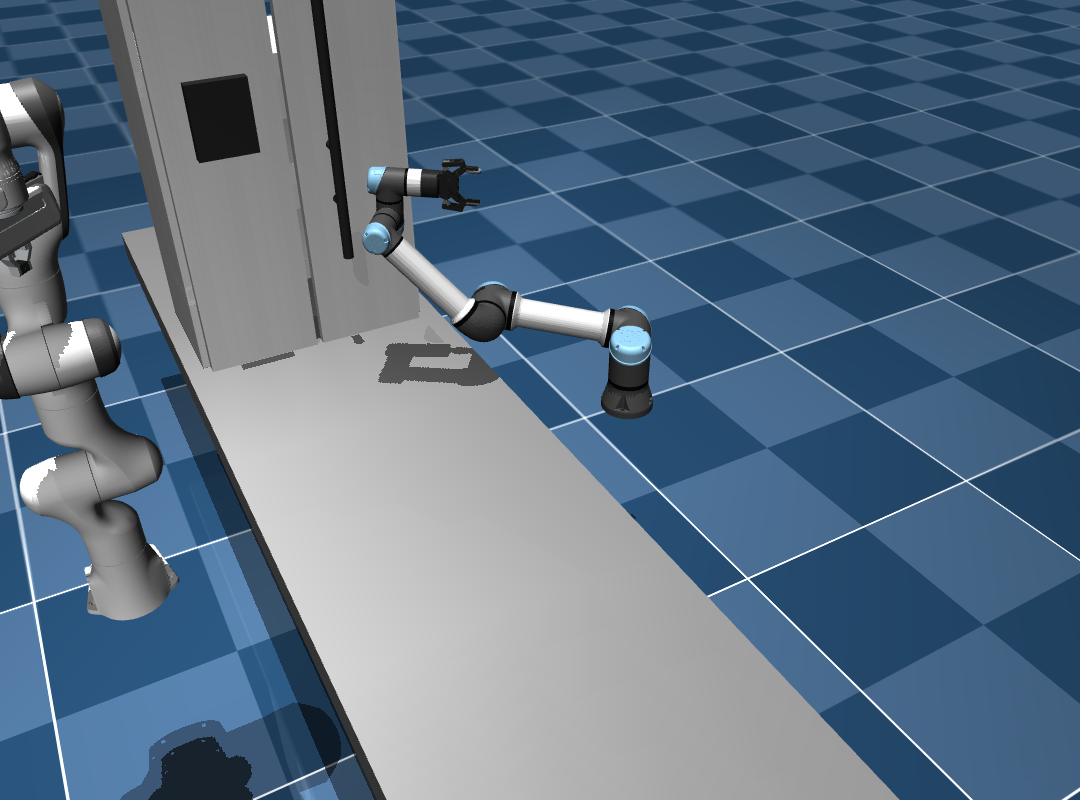

In [28]:
# traj["panda"]["position"][-1]
### Rendering Panda against Keycard ###
# doorcabinet.render_image(cam_id = 0, qpos = traj["panda"]["position"][-1], qpos_id = doorcabinet.joint_ids["panda"]["qpos"])

### Rendering UR5e against Door Handle ###
doorcabinet.render_image(cam_id = 0, qpos = traj["ur5e"]["position"][-1], qpos_id = doorcabinet.joint_ids["ur5e"]["qpos"])



In [86]:
### Visualize the first trajectory ###
doorcabinet.visualize_traj(traj, grasps={"keycard": key_grasp_idx, "door": door_grasp_idx}, duration = 10)
# doorcabinet.render_scene(doorcabinet.frames)

## AA203 Final Project MPC Implementation

In [55]:
## Import MPC Functions
from curobo.wrap.reacher.mpc import MpcSolver, MpcSolverConfig
from curobo.types.state import JointState
from curobo.rollout.rollout_base import Goal

In [63]:
## Use existing World Configs ##

## Doorhandle: UR5E, Keycard: Panda, Keyreader: Panda

def solve_mpc(physics, robot_file, robot_joint_ids, world_config, traj):
    mpc_config = MpcSolverConfig.load_from_robot_config(
        robot_file,
        world_config,
        store_rollouts=True,
        step_dt=0.03,
    )
    mpc = MpcSolver(mpc_config)

    retract_cfg = mpc.rollout_fn.dynamics_model.retract_config.clone().unsqueeze(0)

    kinematics_state = mpc.rollout_fn.compute_kinematics(
        JointState.from_position(retract_cfg + 0.5, joint_names=mpc.joint_names)
    )
    
    goal_pose = kinematics_state.ee_pose.clone()


    ##Store idxs of qpos and ctrl
    qpos_ids = robot_joint_ids["qpos"]
    ctrl_ids = robot_joint_ids["ctrl"]



    # read start state from robot here:
    start_state = JointState.from_position(retract_cfg, joint_names=mpc.joint_names)

    goal = Goal(
        current_state=start_state,
        goal_state=JointState.from_position(retract_cfg, joint_names=mpc.joint_names),
        goal_pose=goal_pose,
    )

    goal_buffer = mpc.setup_solve_single(goal, 1)


    mpc.update_goal(goal_buffer)

    # using an iterator to prevent infinite loop
 

    for ep in range(len(traj)):
        new_goal_state = JointState.from_position(traj[ep].view(1, -1), joint_names=mpc.joint_names)
        goal_buffer.goal_state.copy_(new_goal_state) # for joint configuration
        mpc.enable_pose_cost(enable=False)
        mpc.enable_cspace_cost(enable=True)
        mpc.update_goal(goal_buffer)
        i = 0
        while True and i < 100: # control loop

            # To change goal pose:
            # goal_buffer.goal_pose.copy_(new_pose) # for Cartesian Pose
            # mpc.enable_pose_cost(enable=True)
            # mpc.enable_cspace_cost(enable=False)
            

            # read current state from robot
            # current_state = your_robot_api.current_state() # convert to JointState
            current_state = JointState.from_position(
                torch.tensor([physics.data.qpos[qpos_ids].copy()], device=device).view(1, -1), 
                joint_names=mpc.joint_names)

            # run MPC:
            result = mpc.step(current_state)

            # send action to robot:
            command = result.action # Result is in JointState format
            # print(command)

            # your_robot_api.send_command(command)
            physics.data.ctrl[ctrl_ids] = command.position.cpu().detach().numpy()
            physics.step()
            
            print(result.metrics.pose_error.item())

            # setting new current state from last command for this example:
            # comment this out and instead read state from your robot.
            # start_state = command
            start_state = JointState.from_position(
                torch.tensor([physics.data.qpos[qpos_ids].copy()], device=device).view(1, -1), 
                joint_names=mpc.joint_names)
            
            i += 1


In [64]:
solve_mpc(doorcabinet.physics, "franka_mobile.yml", doorcabinet.joint_ids["panda"], panda_world_config.world_config, panda_trajectory)

5.450428009033203
5.454826354980469
5.458529949188232
5.4575066566467285
5.456161022186279
5.452764987945557
5.448994159698486
5.446315765380859
5.439810752868652
5.4321417808532715
5.423924922943115
5.416924953460693
5.411988735198975
5.406698226928711
5.398216724395752
5.386717796325684
5.378793239593506
5.372444152832031
5.374973297119141
5.382007122039795
5.391927242279053
5.401413917541504
5.404560089111328
5.408106327056885
5.4101691246032715
5.413637638092041
5.416370391845703
5.420841693878174
5.424870014190674
5.431130886077881
5.436701774597168
5.442295551300049
5.447502136230469
5.451950550079346
5.455362319946289
5.457370758056641
5.457367420196533
5.45728063583374
5.454036712646484
5.450162887573242
5.445102691650391
5.438991546630859
5.432560443878174
5.426321983337402
5.421510219573975
5.418882369995117
5.418608665466309
5.421188831329346
5.425563812255859
5.431819438934326
5.4378275871276855
5.441993236541748
5.4491071701049805
5.456423759460449
5.464498519897461
5.4714

KeyboardInterrupt: 

In [24]:
from curobo.wrap.reacher.mpc import MpcSolver, MpcSolverConfig
from curobo.types.state import JointState
from curobo.rollout.rollout_base import Goal

# create a world representation
world_config = {
        "cuboid": {
            "table": {"dims": [2, 2, 0.2], "pose": [0.4, 0.0, -0.1, 1, 0, 0, 0]},
            "cube_1": {"dims": [0.1, 0.1, 0.2], "pose": [0.4, 0.0, 0.5, 1, 0, 0, 0]},
        },
        # "mesh": {
        #     "scene": {
        #         "pose": [1.5, 0.080, 1.6, 0.043, -0.471, 0.284, 0.834],
        #         "file_path": "scene/nvblox/srl_ur10_bins.obj",
        #     }
        # },
    }

mpc_config = MpcSolverConfig.load_from_robot_config(
        "ur5e.yml",
        world_config,
        store_rollouts=True,
        step_dt=0.03,
    )
mpc = MpcSolver(mpc_config)


retract_cfg = mpc.rollout_fn.dynamics_model.retract_config.clone().unsqueeze(0)
print(retract_cfg.shape)

kinematics_state = mpc.rollout_fn.compute_kinematics(
    JointState.from_position(retract_cfg + 0.5, joint_names=mpc.joint_names)
)
goal_pose = kinematics_state.ee_pose.clone()


# read start state from robot here:
start_state = JointState.from_position(retract_cfg, joint_names=mpc.joint_names)

goal = Goal(
    current_state=start_state,
    goal_state=JointState.from_position(retract_cfg, joint_names=mpc.joint_names),
    goal_pose=goal_pose,
)

goal_buffer = mpc.setup_solve_single(goal, 1)


mpc.update_goal(goal_buffer)

# using an iterator to prevent infinite loop
i = 0

while True and i < 100: # control loop

    # To change goal pose:
    # goal_buffer.goal_pose.copy_(new_pose) # for Cartesian Pose
    # mpc.enable_pose_cost(enable=True)
    # mpc.enable_cspace_cost(enable=False)
    #
    # To change goal state:
    # goal_buffer.goal_state.copy_(new_goal_state) # for joint configuration
    # mpc.enable_pose_cost(enable=False)
    # mpc.enable_cspace_cost(enable=True)


    # mpc.update_goal(goal_buffer)


    # read current state from robot
    # current_state = your_robot_api.current_state() # convert to JointState

    current_state = start_state

    # run MPC:
    result = mpc.step(current_state)

    # send action to robot:
    command = result.action
    # print(command.position)
    # your_robot_api.send_command(command)
    print(result.metrics.pose_error.item())

    # setting new current state from last command for this example:
    # comment this out and instead read state from your robot.
    start_state = command

    i += 1

torch.Size([1, 6])
3.814150810241699
3.812209129333496
3.8040668964385986
3.779219627380371
3.7388761043548584
3.6723499298095703
3.5746614933013916
3.4451770782470703
3.278599739074707
3.077343463897705
2.8467214107513428
2.5935661792755127
2.31723690032959
2.0333495140075684
1.7482571601867676
1.479249358177185
1.235515832901001
1.0210107564926147
0.8403723835945129
0.6934440732002258
0.5792534947395325
0.4942251443862915
0.42559945583343506
0.36788704991340637
0.3174724578857422
0.271965354681015
0.22928056120872498
0.19328391551971436
0.15973660349845886
0.13639165461063385
0.12527914345264435
0.12306205183267593
0.12231729179620743
0.121529720723629
0.11823774874210358
0.11388184130191803
0.10852804780006409
0.10224025696516037
0.09888169914484024
0.09736394137144089
0.09744016081094742
0.09947536885738373
0.10207884758710861
0.10361681133508682
0.1036093533039093
0.10459096729755402
0.10419723391532898
0.10395322740077972
0.10238216817378998
0.09943047165870667
0.0954276248812675

# Leaf Raking Task 

In [8]:
class LeafRakeTask(BaseTask):

    def __init__(self, model_name:str = "") -> None:
        super().__init__(model_name) # Sets global params

        ## Set default ##
        self.set_defaults()

        ## Add assets: textures, materials, etc
        self.add_assets()

        ## Add objects elements and build env
        self.build_scene()

        # self.physics = mjcf.Physics.from_mjcf_model(self.model)

    def delete(self,):
        del self.model
        del self.physics

    def set_physics(self,):
        self.physics = mjcf.Physics.from_mjcf_model(self.model)
                
    def set_defaults(self,):
        self.model.default.joint.limited = True 
        self.model.default.joint.damping = 1
        self.model.default.joint.armature = 0
        self.model.default.geom.contype = 1
        self.model.default.geom.conaffinity = 1
        self.model.default.geom.condim = 3
        self.model.default.geom.rgba = [0.8, 0.6, 0.4, 1]
        self.model.default.geom.margin = 0.001
        self.model.default.geom.solref = [0.02, 1]
        self.model.default.geom.solimp = [0.8, 0.8, 0.01]
        self.model.default.geom.material = "geom"

#           <extension>
#     <plugin plugin="mujoco.elasticity.shell" />
#   </extension>
        self.model.extension.add('plugin', plugin="mujoco.elasticity.shell")

    def add_assets(self,):
        self.model.asset.add("texture", type="skybox", builtin="gradient", width="128", height="128", rgb1=".4 .6 .8", rgb2="0 0 0")
        self.model.asset.add("texture", name="texgeom", type="cube", builtin="flat", mark="cross", width="127", height="1278", rgb1="0.8 0.6 0.4", rgb2="0.8 0.6 0.4", markrgb="1 1 1", random="0.01")
        self.model.asset.add("texture", name="texplane", type="2d", builtin="checker", rgb1=".2 .3 .4", rgb2=".1 0.15 0.2", width="512", height="512")

        self.model.asset.add("material", name='MatPlane', reflectance='0.5', texture="texplane", texrepeat="1 1", texuniform="true")
        self.model.asset.add("material", name='geom', texture="texgeom", texuniform="true")

    def build_scene(self,):
        
        ## Add table ##
        self.model.worldbody.add("geom", name="floor", pos=[0, 0, -0.8], size=[3, 3, 0.125], type="plane", material="MatPlane", condim=3)
        self.model.worldbody.add("geom", name="table_top", pos=[0, 1, -0.04], size=[0.5, 0.5, 0.04], type="box")
        self.model.worldbody.add("geom", name="table_leg", pos=[0, 1, -0.408], size=[0.05, 0.05, 0.4], type="box")

        ## Add cloth ##
        # self.cloth_body = self.model.worldbody.add("body", name="clothB0_0", pos=[-0.3, 0, 0], euler=[-1.57, 0, 0])
        # self.cloth_body.add("freejoint", name="cloth_freejoint") 
        # self.cloth_composite = self.cloth_body.add("composite", prefix="cloth", type="cloth", count=[13, 13, 1], spacing=0.05, flatinertia=0.01)
        # self.cloth_composite.add("joint", kind="main", damping=0.001)
        # self.cloth_composite.add("joint", kind="twist", damping=0.0001)

        # self.cloth_composite.geom.type = "capsule"
        # self.cloth_composite.geom.size = [0.015, 0.01]
        # self.cloth_composite.geom.rgba = [0.8, 0.2, 0.1, 1]
        # self.cloth_composite.geom.friction = [0.1, 0.005, 0.0001]
        # self.cloth_composite.geom.mass = 0.003

        # self.cloth_composite.skin.material = "geom"
        # self.cloth_composite.skin.texcoord = "true"
        # self.cloth_composite.skin.inflate = 0.005
        # self.cloth_composite.skin.subgrid = 2

        ## Add bag ##
        
        
        # self.cloth_composite.add("geom", type="capsule", size =[0.015, 0.01], rgba=[0.8,0.2,0.1,1], friction=[0.1, 0.005, 0.0001], mass=0.003)       
        # self.cloth_composite.add("skin", material="geom", texcoord="true", inflate="0.005", subgrid="2")

    def add_robots(self, robot_dict, create_weld = False):
        #Generalize for multiple robots/arms
        self.robot_models = {}

        for robot_name, robot_data in robot_dict.items():   
            
            #Create robot model to attach to mujoco world model
            robot = mjcf.from_path(robot_data["file"])
            robot.model = robot_name
            robot_site = self.model.worldbody.add('site', name=robot_name, pos=robot_data["worldbody_site_pos"], size=[0.001, 0.001, 0.001])
            robot_site.attach(robot)
            self.robot_models[robot_name] = deepcopy(robot)
            del robot, robot_site

    def render(self, camera_id = None, width=1080, height=800):
        if camera_id is None:
            img = PIL.Image.fromarray(self.physics.render(width = width, height = height))
        else:
            img = PIL.Image.fromarray(self.physics.render(camera_id = camera_id, width = width, height = height))
        return img

In [9]:
# leafrake = LeafRakeTask("leafrake")
# leafrake.set_physics()
# leafrake.render()

In [10]:
robots = { "panda1": {
                "robot_config": append_robot_names("panda1", PANDA_CONSTANTS.copy()),
                "robot_type": "panda1",
                "file": 'rocobench/envs/assets/panda/panda.xml',
                "worldbody_site_pos": [0.6, 0.0, -0.75]
            },

            "panda2": {
                "robot_config": append_robot_names("panda2", PANDA_CONSTANTS.copy()),
                "robot_type": "panda2",
                "file": 'rocobench/envs/assets/panda/panda.xml',
                "worldbody_site_pos": [-0.6, 0.0, -0.75]
            },

            # "ur5e":{
            #     "robot_config": append_robot_names("ur5e", UR5E_ROBOTIQ_CONSTANTS.copy()),
            #     "robot_type": "ur5e",
            #     "file": 'rocobench/envs/assets/ur5e_robotiq/ur5e_robotiq_full.xml',
            #     "worldbody_site_pos": [0.2, 1.2, 0.1]
            # }
        }
leafrake = leafrake = LeafRakeTask("leafrake")
leafrake.add_robots(robot_dict=robots)
leafrake.set_physics()
leafrake.render()




AttributeError: <plugin> is not a valid child of <extension>

In [25]:
# leafrake.cloth_body.pos = [-0.4, -0.5, -0.79]
# # leafrake.cloth_body.euler = [0., 0, 0]
# # leafrake.cloth_composite.geom.size = [0.015, 0.01]
# leafrake.cloth_composite.count = [15, 30, 1]

# leafrake.set_physics()
# leafrake.render()

In [26]:
    # <!-- Shirt -->
    # <flexcomp name="shirt_flex" type="mesh" radius="0.01" dim="2" pos="0 0 2"
    #   file="shirt_lowpoly_tetra_again.obj">
    #   <contact solref="0.003" selfcollide="none" />
    #   <edge equality="true" damping="0.1" />
    #   <plugin plugin="mujoco.elasticity.shell">
    #     <config key="poisson" value="0" />
    #     <config key="thickness" value="8e-3" />
    #     <config key="young" value="3e5" />
    #   </plugin>
    # </flexcomp>

## Add extension to model options


flexcomp_model = leafrake.model.worldbody.add('flexcomp', name="bag", type="mesh", radius="0.01", 
                             dim="2", pos="0 0 2", file="rocobench/envs/assets/objects/meshes/bag0_0.obj") 

AttributeError: <flexcomp> is not a valid child of <worldbody>

In [20]:
import mujoco

In [84]:
bag_xml = """ 

<mujoco model="Bag">
  <option timestep="0.0002" solver="CG" iterations="30" tolerance="1e-6" />

  <size memory="200M" />

  <extension>
    <plugin plugin="mujoco.elasticity.shell" />
  </extension>

  <visual>
    <map force="0.1" zfar="30" />
    <rgba haze="0.15 0.25 0.35 1" />
    <quality shadowsize="2048" />
    <global offwidth="2000" offheight="2000" />
  </visual>

  <asset>
    <texture name="plane" type="2d" builtin="checker" rgb1=".2 .3 .4" rgb2=".1 0.15 0.2"
      width="512" height="512" mark="cross" markrgb=".8 .8 .8" />
    <texture name="hammock" type="2d" builtin="checker" rgb1=".1 .5 .1" rgb2=".5 .1 .1"
      width="512" height="512" mark="edge" markrgb=".8 .8 .8" />
    <material name="plane" reflectance="0.3" texture="plane" texrepeat="1 1" texuniform="true" />
    <material name="hammock" texture="hammock" />
  </asset>


  <worldbody>
    <geom name="floor" pos="0 0 -1" size="0 0 .25" type="plane" material="plane" condim="3" />

    <!-- Shirt -->
    <flexcomp name="bag_flex" type="mesh" radius="0.01" dim="2" pos="0 0 0" quat="-0.5 -0.5 0.5 0.5" 
      file="rocobench/envs/assets/objects/meshes/bag0_0.obj">
      <contact solref="0.003" selfcollide="none" />
      <edge equality="true" damping="0.1" />
      <plugin plugin="mujoco.elasticity.shell">
        <config key="poisson" value="0" />
        <config key="thickness" value="8e-3" />
        <config key="young" value="3e5" />
      </plugin>
    </flexcomp>

    <!-- Lights -->
    <light directional="true" diffuse=".2 .2 .2" specular="0 0 0" pos="0 0 5" dir="0 0 -1"
      castshadow="false" />
    <light directional="false" diffuse=".8 .8 .8" specular="0.3 0.3 0.3" pos="0 0 4" dir="0 0 -1" />
  </worldbody>
</mujoco>
"""

bag_model = mujoco.MjModel.from_xml_string(bag_xml)


In [85]:

import mujoco.renderer

bag_data = mujoco.MjData(bag_model)
renderer = mujoco.renderer.Renderer(bag_model, height=600, width=800)

In [86]:
bag_data.xpos.shape

(1278, 3)

600


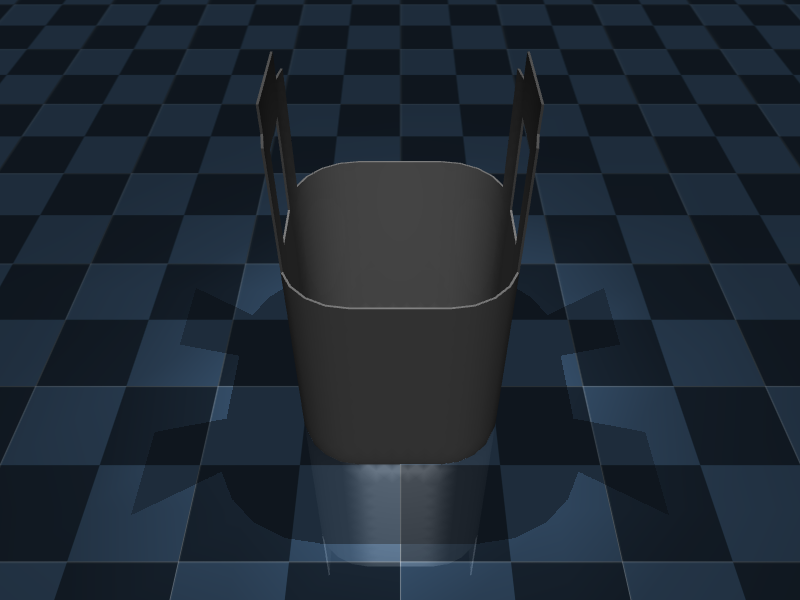

In [87]:


print(renderer.height)

mujoco.mj_forward(bag_model, bag_data)
renderer.update_scene(bag_data)

PIL.Image.fromarray(renderer.render())

In [88]:
bag_physics = dm_mujoco.Physics.from_xml_string(bag_xml)

KeyError: 'name_flexadr'

In [90]:
bag_physics = mjcf.Physics.from_xml_string(bag_xml)

KeyError: 'name_flexadr'